# Predicting the Duration of NY City Taxi Rides: A Project in Predictive Analytics with Feature Engineering
---------------
## **Background**
---------------

Taxis provide an important means of alternative transportation for New York City commuters, and data on these rides can give us a better understanding about peak traffic times, transportation costs for taxi users, travel hotspots and commute times, among other insights. Taxi companies (as well as ride-sharing companies like Uber and Lyft) face the challenge of efficiently assigning transport to passengers. Predicting the duration of a current ride can help a taxi cab company predict when a cab will be free for its next trip. It can also be used to determine how much to charge a customer at the outset of the trip. The large data set looked at below contains information on taxi trips in New York City. After cleaning and preprocessing our data and performing exploratory data analysis, I will apply different modeling techniques to predict trip duration. This regression project will engage in feature engineering through Deep Feature Synthesis along with dimensionality reduction with Principal Component Analysis (PCA) to see how the addition and reduction of features can affect models.

---------------
## **About the Data**
---------------

The data used for this project is provided by the New York City Taxi & Limousine Commission. According to the source, the data was "collected and provided to the NYC Taxi and Limousine Commission (TLC) by technology providers authorized under the Taxicab & Livery Passenger Enhancement Programs (TPEP/LPEP). The trip data was not created by the TLC, and TLC makes no representations as to the accuracy of these data." The data used for this project is a subset of the TLC provided data found on Kaggle, and covers over 7 million recorded trips during the month of February in the year 2019 for yellow taxis. The dataset is accessible on kaggle at the following link:
https://www.kaggle.com/datasets/microize/newyork-yellow-taxi-trip-data-2020-2019

The full dataset is available from the TLC website here:
https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page


-----------------
## **Project Objective**
-----------------

- Clean the large dataset and address outliers and mistakes in the dataset
- Perform exploratory data analysis on the dataset with univariate and bivariate analysis.
- Build predictive models for predicting the duration of a taxi ride.
- Use automated feature engineering to create new features with Deep Feature Synthesis, creating transform and aggragate primitives.
- Reduce the total number of features using Principal Component Analysis, and also manually to compare model performance for linear regression.

-----------------
## **Dataset**
-----------------

The original ``trips`` table has the following fields
* ``vendor_id`` is the technology provider that provided the record (1=Creative Mobile Technologies, 2=VeriFone Inc.)
* ``tpep_pickup_datetime`` the time stamp for pickup
* ``tpep_dropoff_datetime`` the time stamp for drop-off
* ``passenger_count`` the number of passengers for the trip
* ``trip_distance`` total distance of the trip in miles 
* ``PULocationID`` TLC Taxi Zone in which the taximeter was engaged
* ``DOLocationID`` TLC Taxi Zone in which the taximeter was disengaged
* ``RateCodeID`` The final rate code in effect at the end of the trip. (1= Standard rate, 2=JFK, 3=Newark, 4=Nassau or Westchester, 5=Negotiated fare, 6=Group ride)
* ``Storeandfwd_flag`` This flag indicates whether the trip record was held in vehicle memory before sending to the vendor, aka “store and forward," because the vehicle did not have a connection to the server.
* ``payment_type`` a numeric code signifying how the passenger paid for the trip. 1= Credit card 2= Cash 3= No charge 4= Dispute 5= Unknown 6= Voided
* ``Fare_amount`` The time-and-distance fare calculated by the meter.
* ``Extra`` Miscellaneous extras and surcharges. Currently, this only includes the 0.50 and 1 dollar rush hour and overnight charges.
* ``MTA_tax`` 0.50 MTA tax that is automatically triggered based on the metered rate in use.
* ``Improvement_surcharge`` 0.30 improvement surcharge assessed trips at the flag drop. The improvement surcharge began being levied in 2015.
* ``Tip_amount``  populated for credit card tips. Cash tips are not included.
* ``Tolls_amount``  Total amount of all tolls paid in trip.
* ``Total_amount``  total amount charged to passengers. Does not include cash tips.

### Importing libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Feataurestools for feature engineering
import featuretools as ft

# For splitting arrays / matrices into random train and test subsets.
from sklearn.model_selection import train_test_split

# For replacing missing values:
from sklearn.impute import SimpleImputer

# Importing gradient boosting regressor (calculates the difference between the prediction and the correct value), for making prediction

# R^2 (coefficient of determination) regression score function (ranged from 0-1)
# Assesses the ability of a linear regression model to predict an outcome
from sklearn.metrics import r2_score

# For linear regression modeling
from sklearn.linear_model import LinearRegression

# For random forest and decision tree regressors:
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

# Import standard featuretools primitives
from featuretools.primitives import (Minute, Hour, Day, Month,
                                     Weekday, IsWeekend, Count, Sum, Mean, Median, Std, Min, Max)

# Verify featuretools version:
print(ft.__version__)

# Automatically reload modules before execution of code:
%load_ext autoreload
%autoreload 2

0.27.0


In [2]:
# set global random seed for reproducibility
np.random.seed(40)

In [3]:
trips = pd.read_csv('/yellow_tripdata_2019-02.csv',
                        parse_dates=["tpep_pickup_datetime","tpep_dropoff_datetime"],
                        dtype={'vendor_id':'category','payment_type':'category','passenger_count':'int64'},
                        encoding='utf-8')
trips["payment_type"] = trips["payment_type"].apply(str)

In [4]:
trips.info()
trips.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7019375 entries, 0 to 7019374
Data columns (total 18 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               int64         
 1   tpep_pickup_datetime   datetime64[ns]
 2   tpep_dropoff_datetime  datetime64[ns]
 3   passenger_count        int64         
 4   trip_distance          float64       
 5   RatecodeID             int64         
 6   store_and_fwd_flag     object        
 7   PULocationID           int64         
 8   DOLocationID           int64         
 9   payment_type           category      
 10  fare_amount            float64       
 11  extra                  float64       
 12  mta_tax                float64       
 13  tip_amount             float64       
 14  tolls_amount           float64       
 15  improvement_surcharge  float64       
 16  total_amount           float64       
 17  congestion_surcharge   float64       
dtypes: category(1), dateti

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge
0,1,2019-02-01 00:59:04,2019-02-01 01:07:27,1,2.1,1,N,48,234,1,9.0,0.5,0.5,2.0,0.0,0.3,12.3,0.0
1,1,2019-02-01 00:33:09,2019-02-01 01:03:58,1,9.8,1,N,230,93,2,32.0,0.5,0.5,0.0,0.0,0.3,33.3,0.0
2,1,2019-02-01 00:09:03,2019-02-01 00:09:16,1,0.0,1,N,145,145,2,2.5,0.5,0.5,0.0,0.0,0.3,3.8,0.0
3,1,2019-02-01 00:45:38,2019-02-01 00:51:10,1,0.8,1,N,95,95,2,5.5,0.5,0.5,0.0,0.0,0.3,6.8,0.0
4,1,2019-02-01 00:25:30,2019-02-01 00:28:14,1,0.8,1,N,140,263,2,5.0,0.5,0.5,0.0,0.0,0.3,6.3,0.0


In [5]:
# The data file containing over 7 million entries will be too large to process.
# A shorter version with ~2 million entries will be suitable for the project.

# I will drop some unnecessary columns first
trips = trips.drop(["VendorID", "RatecodeID", "store_and_fwd_flag", 
                    "extra", "mta_tax", "tolls_amount", "improvement_surcharge", "congestion_surcharge"],axis=1)

trips.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7019375 entries, 0 to 7019374
Data columns (total 10 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   tpep_pickup_datetime   datetime64[ns]
 1   tpep_dropoff_datetime  datetime64[ns]
 2   passenger_count        int64         
 3   trip_distance          float64       
 4   PULocationID           int64         
 5   DOLocationID           int64         
 6   payment_type           category      
 7   fare_amount            float64       
 8   tip_amount             float64       
 9   total_amount           float64       
dtypes: category(1), datetime64[ns](2), float64(4), int64(3)
memory usage: 488.7 MB


In [6]:
# Remove 5 million random rows:

remove_n = 5000000
drop_indices = np.random.choice(trips.index, remove_n, replace=False)
trips = trips.drop(drop_indices)

In [7]:
# Memory usage looks much better. Number of records now 2,019,375

trips.info()
trips.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2019375 entries, 3 to 7019373
Data columns (total 10 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   tpep_pickup_datetime   datetime64[ns]
 1   tpep_dropoff_datetime  datetime64[ns]
 2   passenger_count        int64         
 3   trip_distance          float64       
 4   PULocationID           int64         
 5   DOLocationID           int64         
 6   payment_type           category      
 7   fare_amount            float64       
 8   tip_amount             float64       
 9   total_amount           float64       
dtypes: category(1), datetime64[ns](2), float64(4), int64(3)
memory usage: 156.0 MB


,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,PULocationID,DOLocationID,payment_type,fare_amount,tip_amount,total_amount
3,2019-02-01 00:45:38,2019-02-01 00:51:10,1,0.8,95,95,2,5.5,0.00,6.80
5,2019-02-01 00:38:02,2019-02-01 00:40:57,1,0.8,229,141,2,4.5,0.00,5.80
6,2019-02-01 00:06:49,2019-02-01 00:10:34,1,0.9,75,41,2,5.0,0.00,6.30
12,2019-02-01 00:15:53,2019-02-01 00:25:41,2,1.8,68,246,1,9.0,2.05,12.35
13,2019-02-01 00:28:54,2019-02-01 00:33:51,1,0.8,246,68,1,5.5,2.00,8.80


In [8]:
# Assign a unique trip ID to every trip

trips.insert(0, 'Trip_ID', range(1, 1+len(trips)))

# Create a duration column (in minutes) that subtracts the pickup time from the dropoff time
trips.insert(4, 'duration', round(((trips['tpep_dropoff_datetime'] - trips['tpep_pickup_datetime']).dt.total_seconds() / 60),2))

In [9]:
# Verify:
trips

,Trip_ID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,duration,trip_distance,PULocationID,DOLocationID,payment_type,fare_amount,tip_amount,total_amount
3,1,2019-02-01 00:45:38,2019-02-01 00:51:10,1,5.53,0.80,95,95,2,5.5,0.00,6.80
5,2,2019-02-01 00:38:02,2019-02-01 00:40:57,1,2.92,0.80,229,141,2,4.5,0.00,5.80
6,3,2019-02-01 00:06:49,2019-02-01 00:10:34,1,3.75,0.90,75,41,2,5.0,0.00,6.30
12,4,2019-02-01 00:15:53,2019-02-01 00:25:41,2,9.80,1.80,68,246,1,9.0,2.05,12.35
13,5,2019-02-01 00:28:54,2019-02-01 00:33:51,1,4.95,0.80,246,68,1,5.5,2.00,8.80
...,...,...,...,...,...,...,...,...,...,...,...,...
7019355,2019371,2019-02-28 23:56:54,2019-03-01 00:06:45,1,9.85,3.10,162,75,1,10.5,2.85,17.15
7019359,2019372,2019-02-28 23:36:21,2019-02-28 23:46:23,1,10.03,1.30,137,229,2,6.0,0.00,9.80
7019360,2019373,2019-02-28 23:07:53,2019-02-28 23:46:52,1,38.98,4.34,163,4,1,24.5,4.24,32.54
7019366,2019374,2019-02-28 23:11:03,2019-02-28 23:17:14,1,6.18,1.22,48,143,1,6.5,1.00,11.30


In [10]:
# Import the taxi zone dataframe, containing information on dropoff and pickup locations:

zones = pd.read_csv('/taxi_zone_lookup.csv')

In [11]:
# Verify:

zones.head()

,LocationID,Borough,Zone,service_zone
0,1,EWR,Newark Airport,EWR
1,2,Queens,Jamaica Bay,Boro Zone
2,3,Bronx,Allerton/Pelham Gardens,Boro Zone
3,4,Manhattan,Alphabet City,Yellow Zone
4,5,Staten Island,Arden Heights,Boro Zone


In [12]:
# Merge tables on the pick-up location via left join. The merged data will be used later for our histograms.
# Drop the column LocationID merged from the dataframe Zones so no duplicate column, rename the added Zone column
# so we know it's for PickUp/Dropoff

trips = pd.merge(trips, zones[['LocationID','Zone']],
         left_on='PULocationID', right_on='LocationID', 
         how='left').drop(columns=['LocationID']).rename(columns={'Zone':'PUZone'})

# Do the same for the drop off location:
trips = pd.merge(trips, zones[['LocationID','Zone']],
         left_on='DOLocationID', right_on='LocationID', 
         how='left').drop(columns=['LocationID']).rename(columns={'Zone':'DOZone'})

In [13]:
# Verify:

trips

,Trip_ID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,duration,trip_distance,PULocationID,DOLocationID,payment_type,fare_amount,tip_amount,total_amount,PUZone,DOZone
0,1,2019-02-01 00:45:38,2019-02-01 00:51:10,1,5.53,0.80,95,95,2,5.5,0.00,6.80,Forest Hills,Forest Hills
1,2,2019-02-01 00:38:02,2019-02-01 00:40:57,1,2.92,0.80,229,141,2,4.5,0.00,5.80,Sutton Place/Turtle Bay North,Lenox Hill West
2,3,2019-02-01 00:06:49,2019-02-01 00:10:34,1,3.75,0.90,75,41,2,5.0,0.00,6.30,East Harlem South,Central Harlem
3,4,2019-02-01 00:15:53,2019-02-01 00:25:41,2,9.80,1.80,68,246,1,9.0,2.05,12.35,East Chelsea,West Chelsea/Hudson Yards
4,5,2019-02-01 00:28:54,2019-02-01 00:33:51,1,4.95,0.80,246,68,1,5.5,2.00,8.80,West Chelsea/Hudson Yards,East Chelsea
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019370,2019371,2019-02-28 23:56:54,2019-03-01 00:06:45,1,9.85,3.10,162,75,1,10.5,2.85,17.15,Midtown East,East Harlem South
2019371,2019372,2019-02-28 23:36:21,2019-02-28 23:46:23,1,10.03,1.30,137,229,2,6.0,0.00,9.80,Kips Bay,Sutton Place/Turtle Bay North
2019372,2019373,2019-02-28 23:07:53,2019-02-28 23:46:52,1,38.98,4.34,163,4,1,24.5,4.24,32.54,Midtown North,Alphabet City
2019373,2019374,2019-02-28 23:11:03,2019-02-28 23:17:14,1,6.18,1.22,48,143,1,6.5,1.00,11.30,Clinton East,Lincoln Square West


# Exploratory Data Analysis

In [14]:
# checking info on the dataset
trips.info()
trips.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2019375 entries, 0 to 2019374
Data columns (total 14 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   Trip_ID                int64         
 1   tpep_pickup_datetime   datetime64[ns]
 2   tpep_dropoff_datetime  datetime64[ns]
 3   passenger_count        int64         
 4   duration               float64       
 5   trip_distance          float64       
 6   PULocationID           int64         
 7   DOLocationID           int64         
 8   payment_type           category      
 9   fare_amount            float64       
 10  tip_amount             float64       
 11  total_amount           float64       
 12  PUZone                 object        
 13  DOZone                 object        
dtypes: category(1), datetime64[ns](2), float64(5), int64(4), object(2)
memory usage: 217.6+ MB


Trip_ID                     0
tpep_pickup_datetime        0
tpep_dropoff_datetime       0
passenger_count             0
duration                    0
trip_distance               0
PULocationID                0
DOLocationID                0
payment_type                0
fare_amount                 0
tip_amount                  0
total_amount                0
PUZone                   1000
DOZone                   4589
dtype: int64

There are some null values in teh PickUp and DropOff Zones that will need to be explored.

In [15]:
# Check the uniques values in each columns
trips.nunique()

Trip_ID                  2019375
tpep_pickup_datetime     1269049
tpep_dropoff_datetime    1269686
passenger_count               10
duration                    8951
trip_distance               3556
PULocationID                 260
DOLocationID                 261
payment_type                   4
fare_amount                 4457
tip_amount                  2478
total_amount                8965
PUZone                       258
DOZone                       259
dtype: int64

- We see passenger count has 10 unique values and payment types are only 4.
- There are 258 pick up locations, and 259 drop off locations.

In [16]:
# Descriptive statistics for the data frame

trips.describe().T

,count,mean,std,min,25%,50%,75%,max
Trip_ID,2019375.0,1.009688e+06,582943.494260,1.00,504844.50,1009688.00,1514531.50,2019375.00
passenger_count,2019375.0,1.571401e+00,1.228221,0.00,1.00,1.00,2.00,9.00
duration,2019375.0,1.722992e+01,70.920210,-1388.48,6.45,10.78,17.60,1439.88
trip_distance,2019375.0,2.885612e+00,3.803656,0.00,0.94,1.60,2.91,701.50
PULocationID,2019375.0,1.635127e+02,65.969579,1.00,114.00,162.00,233.00,265.00
DOLocationID,2019375.0,1.618197e+02,70.070541,1.00,112.00,162.00,234.00,265.00
fare_amount,2019375.0,1.264695e+01,16.876662,-215.32,6.50,9.00,14.00,17669.73
tip_amount,2019375.0,2.162668e+00,2.626509,-51.10,0.00,1.86,2.86,300.00
total_amount,2019375.0,1.845774e+01,18.741329,-216.12,11.00,14.16,19.80,17669.73


**Relevant columns for descriptive statistics include passenger_count, duration, trip_distance, and amounts:**
- Median of passenger count is 1, and 75% percentile of the passenger count is 2. 
- Average trip distance = 2.89 miles, max distance = 701.5 miles and minimum distance = 0 miles.
- Average trip duration is 17.23 minutes long with the median being 10.78 minutes.
- There are some negative values in our duration and fare/tip/total amounts that will need to be addressed.
- Mean total charged is about 18.46 for a trip.

## Cleaning Our Data:

In [17]:
# Check for rows where there were 0 passengers (reported in the descriptive statistics above)

trips[trips['passenger_count'] == 0]

,Trip_ID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,duration,trip_distance,PULocationID,DOLocationID,payment_type,fare_amount,tip_amount,total_amount,PUZone,DOZone
23,24,2019-02-01 00:17:37,2019-02-01 00:25:01,0,7.40,1.1,233,48,1,6.5,1.55,9.35,UN/Turtle Bay South,Clinton East
42,43,2019-02-01 00:45:14,2019-02-01 01:13:49,0,28.58,6.4,142,83,1,23.5,0.00,24.80,Lincoln Square East,Elmhurst/Maspeth
125,126,2019-02-01 00:48:53,2019-02-01 00:52:17,0,3.40,0.7,163,48,1,4.5,1.15,6.95,Midtown North,Clinton East
234,235,2019-02-01 00:18:24,2019-02-01 00:23:50,0,5.43,1.4,249,107,1,6.5,1.00,8.80,West Village,Gramercy
419,420,2019-02-01 00:23:48,2019-02-01 00:35:02,0,11.23,2.3,107,163,1,10.0,3.00,14.30,Gramercy,Midtown North
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019268,2019269,2019-02-28 23:03:31,2019-02-28 23:14:32,0,11.02,2.5,48,238,1,10.5,2.85,17.15,Clinton East,Upper West Side North
2019269,2019270,2019-02-28 23:55:56,2019-03-01 00:14:10,0,18.23,2.9,230,144,1,13.5,3.45,20.75,Times Sq/Theatre District,Little Italy/NoLiTa
2019285,2019286,2019-02-28 23:12:34,2019-02-28 23:17:37,0,5.05,1.1,164,161,1,6.0,1.95,11.75,Midtown South,Midtown Center
2019304,2019305,2019-02-28 23:34:22,2019-02-28 23:39:23,0,5.02,1.3,142,68,1,6.0,1.95,11.75,Lincoln Square East,East Chelsea


In [18]:
# These appear to represent real trips, just with no passenger.
# I will replace the passenger count for these rows to the median, 1:

trips['passenger_count'] = trips['passenger_count'].replace(0, trips['passenger_count'].median())

In [19]:
# Verify that it worked:

trips[trips['passenger_count'] == 0].count()

Trip_ID                  0
tpep_pickup_datetime     0
tpep_dropoff_datetime    0
passenger_count          0
duration                 0
trip_distance            0
PULocationID             0
DOLocationID             0
payment_type             0
fare_amount              0
tip_amount               0
total_amount             0
PUZone                   0
DOZone                   0
dtype: int64

In [20]:
# Checking the rows for cases where distance was 0
trips[trips['trip_distance']==0]

,Trip_ID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,duration,trip_distance,PULocationID,DOLocationID,payment_type,fare_amount,tip_amount,total_amount,PUZone,DOZone
56,57,2019-02-01 00:01:38,2019-02-01 00:01:41,1,0.05,0.0,264,265,1,50.00,5.00,55.80,NV,NaN
271,272,2019-02-01 00:26:20,2019-02-01 00:26:24,1,0.07,0.0,264,244,2,36.00,0.00,36.30,NV,Washington Heights South
272,273,2019-02-01 00:27:29,2019-02-01 00:29:49,1,2.33,0.0,244,244,2,26.00,0.00,26.30,Washington Heights South,Washington Heights South
273,274,2019-02-01 00:31:22,2019-02-01 00:34:22,1,3.00,0.0,244,244,1,26.00,3.00,29.30,Washington Heights South,Washington Heights South
427,428,2019-02-01 00:06:11,2019-02-01 00:06:19,1,0.13,0.0,137,137,1,11.80,2.42,14.52,Kips Bay,Kips Bay
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018786,2018787,2019-02-28 23:52:54,2019-02-28 23:53:03,1,0.15,0.0,163,163,1,60.00,12.16,72.96,Midtown North,Midtown North
2018832,2018833,2019-02-28 23:37:17,2019-02-28 23:37:40,1,0.38,0.0,68,68,1,0.06,0.67,4.03,East Chelsea,East Chelsea
2019162,2019163,2019-02-28 23:33:53,2019-02-28 23:33:55,3,0.03,0.0,158,264,1,63.00,12.76,76.56,Meatpacking/West Village West,NV
2019342,2019343,2019-02-28 23:27:10,2019-02-28 23:27:21,1,0.18,0.0,158,158,1,52.00,12.21,73.27,Meatpacking/West Village West,Meatpacking/West Village West


- Where trip distance is 0, it is likely a mistake, so we can replace them. 
- There are only 14352 such rows (~0.71% of the data)

In [21]:
# Replacing the 0 values with median of the trip distance
trips['trip_distance'] = trips['trip_distance'].replace(0, trips['trip_distance'].median())

In [22]:
# Verify that it worked:
trips[trips['trip_distance']==0].count()

Trip_ID                  0
tpep_pickup_datetime     0
tpep_dropoff_datetime    0
passenger_count          0
duration                 0
trip_distance            0
PULocationID             0
DOLocationID             0
payment_type             0
fare_amount              0
tip_amount               0
total_amount             0
PUZone                   0
DOZone                   0
dtype: int64

In [23]:
# Checking the rows for cases where duration was 0
trips[trips['duration']==0]

,Trip_ID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,duration,trip_distance,PULocationID,DOLocationID,payment_type,fare_amount,tip_amount,total_amount,PUZone,DOZone
1008,1009,2019-02-01 00:31:15,2019-02-01 00:31:15,2,0.0,1.6,148,264,2,10.5,0.0,11.8,Lower East Side,NV
1858,1859,2019-02-01 00:15:29,2019-02-01 00:15:29,1,0.0,1.6,148,264,2,2.5,0.0,3.8,Lower East Side,NV
3239,3240,2019-02-01 02:07:37,2019-02-01 02:07:37,1,0.0,1.6,238,264,2,4.0,0.0,5.3,Upper West Side North,NV
4001,4002,2019-02-01 03:34:15,2019-02-01 03:34:15,5,0.0,1.6,264,264,2,2.5,0.0,3.8,NV,NV
4488,4489,2019-02-01 04:58:01,2019-02-01 04:58:01,1,0.0,1.6,100,264,2,4.5,0.0,5.8,Garment District,NV
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2008130,2008131,2019-02-28 21:29:10,2019-02-28 21:29:10,1,0.0,1.6,234,264,2,2.5,0.0,6.3,Union Sq,NV
2011535,2011536,2019-02-28 22:44:32,2019-02-28 22:44:32,2,0.0,1.6,239,264,2,13.5,0.0,17.3,Upper West Side South,NV
2013310,2013311,2019-02-28 22:32:25,2019-02-28 22:32:25,1,0.0,3.1,114,114,2,16.5,0.0,20.3,Greenwich Village South,Greenwich Village South
2013458,2013459,2019-02-28 22:18:01,2019-02-28 22:18:01,1,0.0,1.6,264,264,2,2.5,0.0,3.8,NV,NV


- Where trip duration is 0 is not a trip that we are interested in and may reflect
a mistake. We therefore replace with the median. This makes up only 1766 rows of the data.

In [24]:
trips['duration'] = trips['duration'].replace(0, trips['duration'].median())

In [25]:
# Verify that it worked:

trips[trips['duration'] == 0].count()

Trip_ID                  0
tpep_pickup_datetime     0
tpep_dropoff_datetime    0
passenger_count          0
duration                 0
trip_distance            0
PULocationID             0
DOLocationID             0
payment_type             0
fare_amount              0
tip_amount               0
total_amount             0
PUZone                   0
DOZone                   0
dtype: int64

In [26]:
# The PUZone and DOZone have null values. Let's explore...
trips[trips['PUZone'].isnull()]

,Trip_ID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,duration,trip_distance,PULocationID,DOLocationID,payment_type,fare_amount,tip_amount,total_amount,PUZone,DOZone
67,68,2019-02-01 00:03:47,2019-02-01 00:04:04,1,0.28,2.50,265,265,3,2.5,0.00,3.80,NaN,NaN
68,69,2019-02-01 00:06:31,2019-02-01 00:08:16,1,1.75,2.50,265,265,1,60.0,10.00,80.80,NaN,NaN
2042,2043,2019-02-01 01:09:40,2019-02-01 01:12:52,1,3.20,0.50,265,265,4,0.0,0.00,0.30,NaN,NaN
4156,4157,2019-02-01 03:22:10,2019-02-01 03:23:06,1,0.93,1.60,265,265,1,30.0,0.00,40.80,NaN,NaN
4850,4851,2019-02-01 05:29:55,2019-02-01 05:34:56,1,5.02,1.24,265,161,1,6.0,1.46,8.76,NaN,Midtown Center
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2010338,2010339,2019-02-28 21:45:52,2019-02-28 21:54:14,1,8.37,2.06,265,265,1,9.0,2.06,12.36,NaN,NaN
2011210,2011211,2019-02-28 22:52:23,2019-02-28 22:54:18,1,1.92,1.40,265,265,1,100.0,0.00,110.80,NaN,NaN
2011241,2011242,2019-02-28 22:33:54,2019-02-28 22:36:42,1,2.80,1.60,265,265,1,75.0,0.00,81.06,NaN,NaN
2011560,2011561,2019-02-28 22:18:28,2019-02-28 22:19:36,1,1.13,1.60,265,265,1,132.0,32.00,167.44,NaN,NaN


In [27]:
trips[trips['DOZone'].isnull()]

,Trip_ID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,duration,trip_distance,PULocationID,DOLocationID,payment_type,fare_amount,tip_amount,total_amount,PUZone,DOZone
56,57,2019-02-01 00:01:38,2019-02-01 00:01:41,1,0.05,1.60,264,265,1,50.0,5.00,55.80,NV,NaN
67,68,2019-02-01 00:03:47,2019-02-01 00:04:04,1,0.28,2.50,265,265,3,2.5,0.00,3.80,NaN,NaN
68,69,2019-02-01 00:06:31,2019-02-01 00:08:16,1,1.75,2.50,265,265,1,60.0,10.00,80.80,NaN,NaN
514,515,2019-02-01 00:52:02,2019-02-01 01:07:53,1,15.85,4.74,50,265,1,45.0,11.26,67.56,Clinton West,NaN
794,795,2019-02-01 00:19:40,2019-02-01 00:33:27,2,13.78,4.20,100,265,3,0.0,0.00,0.30,Garment District,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018733,2018734,2019-02-28 23:35:22,2019-03-01 00:45:30,1,70.13,44.00,162,265,1,178.5,36.45,218.75,Midtown East,NaN
2018976,2018977,2019-02-28 23:47:52,2019-03-01 00:19:34,1,31.70,17.20,138,265,1,48.0,8.00,63.06,LaGuardia Airport,NaN
2019066,2019067,2019-02-28 23:09:10,2019-02-28 23:34:05,1,24.92,11.07,48,265,1,75.0,5.00,82.80,Clinton East,NaN
2019198,2019199,2019-02-28 23:43:04,2019-02-28 23:56:43,1,13.65,3.32,113,265,2,30.5,0.00,41.80,Greenwich Village North,NaN


In [28]:
# These are cases where the LocationID was set to 265,
# which corresponds with a NA value in our data set because it is outside the NY taxi zone which makes sense
# Let's simply replce with "Other" so it's clear it's from outside of the known zones.
# This is better than replacing with the mode in this situation, because they do in fact refer to an 'Other' location:
trips['DOZone'].fillna('Other', inplace=True)
trips['PUZone'].fillna('Other', inplace=True)

In [29]:
# Verify:
trips[trips['DOZone']=='Other']

,Trip_ID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,duration,trip_distance,PULocationID,DOLocationID,payment_type,fare_amount,tip_amount,total_amount,PUZone,DOZone
56,57,2019-02-01 00:01:38,2019-02-01 00:01:41,1,0.05,1.60,264,265,1,50.0,5.00,55.80,NV,Other
67,68,2019-02-01 00:03:47,2019-02-01 00:04:04,1,0.28,2.50,265,265,3,2.5,0.00,3.80,Other,Other
68,69,2019-02-01 00:06:31,2019-02-01 00:08:16,1,1.75,2.50,265,265,1,60.0,10.00,80.80,Other,Other
514,515,2019-02-01 00:52:02,2019-02-01 01:07:53,1,15.85,4.74,50,265,1,45.0,11.26,67.56,Clinton West,Other
794,795,2019-02-01 00:19:40,2019-02-01 00:33:27,2,13.78,4.20,100,265,3,0.0,0.00,0.30,Garment District,Other
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018733,2018734,2019-02-28 23:35:22,2019-03-01 00:45:30,1,70.13,44.00,162,265,1,178.5,36.45,218.75,Midtown East,Other
2018976,2018977,2019-02-28 23:47:52,2019-03-01 00:19:34,1,31.70,17.20,138,265,1,48.0,8.00,63.06,LaGuardia Airport,Other
2019066,2019067,2019-02-28 23:09:10,2019-02-28 23:34:05,1,24.92,11.07,48,265,1,75.0,5.00,82.80,Clinton East,Other
2019198,2019199,2019-02-28 23:43:04,2019-02-28 23:56:43,1,13.65,3.32,113,265,2,30.5,0.00,41.80,Greenwich Village North,Other


In [30]:
# Check null values to confirm they are all gone:
trips.isnull().sum()

Trip_ID                  0
tpep_pickup_datetime     0
tpep_dropoff_datetime    0
passenger_count          0
duration                 0
trip_distance            0
PULocationID             0
DOLocationID             0
payment_type             0
fare_amount              0
tip_amount               0
total_amount             0
PUZone                   0
DOZone                   0
dtype: int64

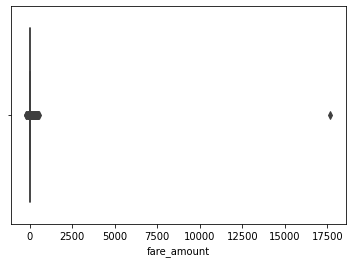

In [31]:
# We had a big outlier for fare_amount and total_amount. Let's look at the outliers for this column:

sns.boxplot(x = trips['fare_amount'])
plt.show()

In [32]:
# Let's dig deeper and look at cases where the fare amount was over $350:

trips[trips['fare_amount'] > 350]

,Trip_ID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,duration,trip_distance,PULocationID,DOLocationID,payment_type,fare_amount,tip_amount,total_amount,PUZone,DOZone
21465,21466,2019-02-01 10:28:47,2019-02-01 12:10:59,1,102.20,93.37,132,265,1,458.00,28.00,486.80,JFK Airport,Other
81190,81191,2019-02-01 22:13:04,2019-02-01 22:13:28,1,0.40,1.60,143,143,3,500.00,0.00,500.30,Lincoln Square West,Lincoln Square West
149355,149356,2019-02-02 20:30:25,2019-02-02 20:31:54,1,1.48,1.60,264,264,3,500.00,0.00,500.30,NV,NV
149356,149357,2019-02-02 20:38:10,2019-02-02 20:39:09,1,0.98,1.60,264,264,1,400.00,0.00,400.30,NV,NV
197110,197111,2019-02-03 15:09:44,2019-02-03 17:19:56,2,130.20,130.53,265,265,1,400.00,15.00,415.80,Other,Other
202866,202867,2019-02-03 16:40:29,2019-02-03 16:41:07,1,0.63,1.60,124,124,1,495.00,0.00,495.30,Howard Beach,Howard Beach
226708,226709,2019-02-04 00:15:03,2019-02-04 00:15:37,1,0.57,1.60,265,265,1,400.00,0.00,400.30,Other,Other
291658,291659,2019-02-04 23:21:06,2019-02-04 23:21:10,2,0.07,1.60,265,265,1,400.00,0.00,400.30,Other,Other
509464,509465,2019-02-07 20:34:55,2019-02-07 20:35:15,1,0.33,1.60,75,75,1,450.00,0.00,450.80,East Harlem South,East Harlem South
907195,907196,2019-02-13 11:31:06,2019-02-13 11:31:06,1,10.78,1.60,264,264,1,17669.73,0.00,17669.73,NV,NV


In [33]:
# Most of these values look like mistakes given the trip distances/duration, 
# e.g. the 1.6 mile trip that cost $17,669.73 (Trip_ID = 907196)!
# I will drop the obvious mistakes (>$350 for trips only 1.6 miles, e.g.) and leave the others.
# E.g., a $400 trip for a 130.53 mile distance is reasonable.

trips = trips.drop(index=[81190,149355,149356,202866,226708,291658,509464,907195,911859,1218586,1368786,1469850,1718846,1718847])

In [34]:
# Verify:
    
trips[trips['fare_amount'] > 350]

,Trip_ID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,duration,trip_distance,PULocationID,DOLocationID,payment_type,fare_amount,tip_amount,total_amount,PUZone,DOZone
21465,21466,2019-02-01 10:28:47,2019-02-01 12:10:59,1,102.20,93.37,132,265,1,458.0,28.00,486.80,JFK Airport,Other
197110,197111,2019-02-03 15:09:44,2019-02-03 17:19:56,2,130.20,130.53,265,265,1,400.0,15.00,415.80,Other,Other
1108087,1108088,2019-02-15 22:52:29,2019-02-16 00:31:44,1,99.25,100.74,132,265,2,499.0,0.00,521.32,JFK Airport,Other
1219456,1219457,2019-02-17 15:55:28,2019-02-17 17:54:00,1,118.53,101.20,138,265,1,400.0,30.00,441.82,LaGuardia Airport,Other
1406406,1406407,2019-02-20 16:36:47,2019-02-20 19:17:18,1,160.52,89.78,70,265,2,400.0,0.00,406.56,East Elmhurst,Other
1612514,1612515,2019-02-23 12:12:58,2019-02-23 14:58:05,1,165.12,111.21,124,138,2,400.0,0.00,442.58,Howard Beach,LaGuardia Airport
1924774,1924775,2019-02-27 20:52:33,2019-02-27 22:33:47,1,101.23,80.80,132,265,1,365.0,27.68,399.74,JFK Airport,Other


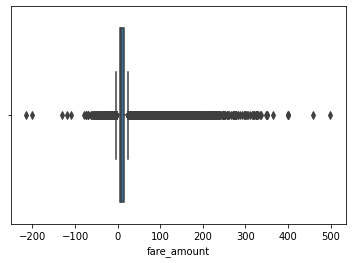

In [35]:
# Now let's check the boxplot:

sns.boxplot(x = trips['fare_amount'])
plt.show()

In [36]:
# There are also cases where the fare amount and total amount were negative. These may be
# refunds or a mistake. Regardless, let's explore:

trips[trips['fare_amount']<=0]

,Trip_ID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,duration,trip_distance,PULocationID,DOLocationID,payment_type,fare_amount,tip_amount,total_amount,PUZone,DOZone
794,795,2019-02-01 00:19:40,2019-02-01 00:33:27,2,13.78,4.20,100,265,3,0.0,0.0,0.30,Garment District,Other
2036,2037,2019-02-01 00:20:44,2019-02-01 00:21:30,1,0.77,1.60,193,193,1,0.0,0.0,0.00,Queensbridge/Ravenswood,Queensbridge/Ravenswood
2042,2043,2019-02-01 01:09:40,2019-02-01 01:12:52,1,3.20,0.50,265,265,4,0.0,0.0,0.30,Other,Other
2762,2763,2019-02-01 01:26:13,2019-02-01 01:35:48,1,9.58,1.88,144,87,4,-8.5,0.0,-9.80,Little Italy/NoLiTa,Financial District North
2763,2764,2019-02-01 01:48:40,2019-02-01 01:54:17,1,5.62,1.93,209,4,4,-8.0,0.0,-9.30,Seaport,Alphabet City
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016319,2016320,2019-02-28 23:00:13,2019-02-28 23:46:15,2,46.03,11.13,164,180,2,0.0,0.0,0.00,Midtown South,Ozone Park
2016529,2016530,2019-02-28 23:05:07,2019-02-28 23:17:22,1,12.25,0.92,164,233,2,-7.0,0.0,-10.80,Midtown South,UN/Turtle Bay South
2018024,2018025,2019-02-28 23:45:22,2019-02-28 23:48:18,1,2.93,0.49,161,161,2,-4.0,0.0,-7.80,Midtown Center,Midtown Center
2019012,2019013,2019-02-28 23:02:48,2019-02-28 23:36:00,1,33.20,18.90,232,183,4,-53.0,0.0,-62.56,Two Bridges/Seward Park,Pelham Bay


In [37]:
# There are 3488 such cases. Without further guidance from the stakeholders who put together the data, we are not sure
# if this is a case where a positive charge was made negative by mistake, whether these are refunds, etc.
# We will drop them so that they do not interfere with our analysis. Similar with charges for $0.

trips.drop(trips[trips['fare_amount']<=0].index, inplace=True)

In [38]:
# Verify:

trips[trips['fare_amount']<=0].count()

Trip_ID                  0
tpep_pickup_datetime     0
tpep_dropoff_datetime    0
passenger_count          0
duration                 0
trip_distance            0
PULocationID             0
DOLocationID             0
payment_type             0
fare_amount              0
tip_amount               0
total_amount             0
PUZone                   0
DOZone                   0
dtype: int64

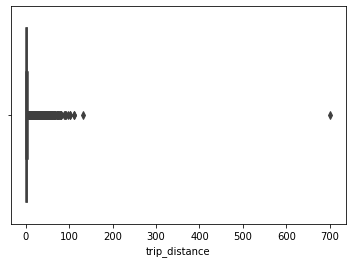

In [39]:
# What about outliers in distance and duration?

# Trip distance boxplot:
sns.boxplot(x = trips['trip_distance'])
plt.show()

In [40]:
trips[trips['trip_distance'] > 200]

,Trip_ID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,duration,trip_distance,PULocationID,DOLocationID,payment_type,fare_amount,tip_amount,total_amount,PUZone,DOZone
43379,43380,2019-02-01 15:53:09,2019-02-01 16:06:15,1,13.1,701.5,114,249,1,10.0,2.7,13.5,Greenwich Village South,West Village


In [41]:
# The above data is a mistake, as it suggests 701.5 miles were traversed in 13.1 minutes. Let's drop:

trips.drop(trips[trips['trip_distance']>200].index, inplace=True)

In [42]:
#Verify:

trips[trips['trip_distance'] > 200].count()

Trip_ID                  0
tpep_pickup_datetime     0
tpep_dropoff_datetime    0
passenger_count          0
duration                 0
trip_distance            0
PULocationID             0
DOLocationID             0
payment_type             0
fare_amount              0
tip_amount               0
total_amount             0
PUZone                   0
DOZone                   0
dtype: int64

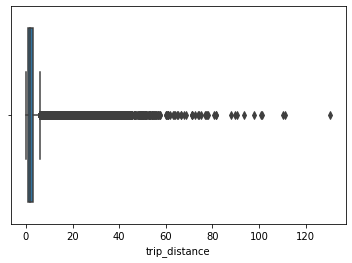

In [43]:
# New trip distance boxplot:
sns.boxplot(x = trips['trip_distance'])
plt.show()

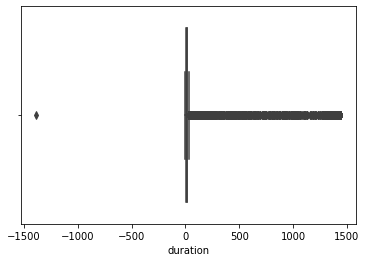

In [44]:
# What about duration?

sns.boxplot(x = trips['duration'])
plt.show()

In [45]:
# Duration < 0 is not possible:

trips[trips['duration'] <= 0]

,Trip_ID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,duration,trip_distance,PULocationID,DOLocationID,payment_type,fare_amount,tip_amount,total_amount,PUZone,DOZone
1622205,1622206,2019-02-23 15:15:25,2019-02-22 16:06:56,1,-1388.48,20.2,132,125,1,52.0,11.05,66.35,JFK Airport,Hudson Sq


In [46]:
# Let's drop it:

trips.drop(trips[trips['duration']<=0].index, inplace=True)

In [47]:
# Verify:

trips[trips['duration'] <= 0].count()

Trip_ID                  0
tpep_pickup_datetime     0
tpep_dropoff_datetime    0
passenger_count          0
duration                 0
trip_distance            0
PULocationID             0
DOLocationID             0
payment_type             0
fare_amount              0
tip_amount               0
total_amount             0
PUZone                   0
DOZone                   0
dtype: int64

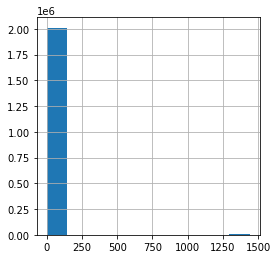

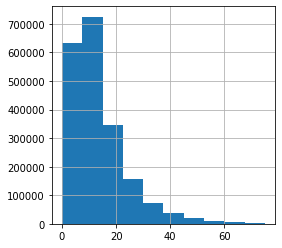

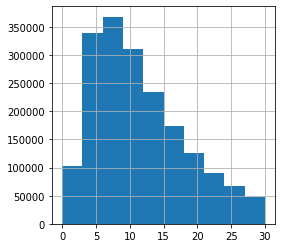

In [48]:
# We also see from the boxplot that there are some trips with durations over an hour long.

# Histograms to see where the data is located:

# Keeping regular scale:
trips['duration'].hist(figsize=(4,4))
plt.show()

# Limiting to range 0 - 75:
trips['duration'].hist(range=[0, 75], figsize=(4,4))
plt.show()

# Limiting to range 0 - 30 where the bulk of values are:
trips['duration'].hist(range=[0, 30], figsize=(4,4))
plt.show()

In [49]:
# Let's explore cases where trip duration > 60 minutes

trips[trips['duration'] > 60]

,Trip_ID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,duration,trip_distance,PULocationID,DOLocationID,payment_type,fare_amount,tip_amount,total_amount,PUZone,DOZone
59,60,2019-01-31 23:57:12,2019-02-01 00:57:37,1,60.42,6.36,261,162,2,32.0,0.00,33.30,World Trade Center,Midtown East
228,229,2019-02-01 00:04:28,2019-02-02 00:00:05,5,1435.62,6.60,90,37,1,28.0,4.40,33.70,Flatiron,Bushwick South
389,390,2019-02-01 00:07:50,2019-02-01 23:52:59,5,1425.15,2.77,186,4,1,12.0,1.33,14.63,Penn Station/Madison Sq West,Alphabet City
801,802,2019-02-01 00:42:57,2019-02-01 23:36:35,1,1373.63,7.03,144,257,2,22.0,0.00,23.30,Little Italy/NoLiTa,Windsor Terrace
1144,1145,2019-02-01 00:09:44,2019-02-02 00:04:39,2,1434.92,0.31,143,143,1,3.0,0.00,4.30,Lincoln Square West,Lincoln Square West
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019042,2019043,2019-02-28 23:36:30,2019-03-01 23:15:08,1,1418.63,1.72,230,233,1,10.5,2.14,16.44,Times Sq/Theatre District,UN/Turtle Bay South
2019137,2019138,2019-02-28 22:40:09,2019-03-01 21:51:36,2,1391.45,1.89,163,90,2,9.5,0.00,13.30,Midtown North,Flatiron
2019236,2019237,2019-02-28 18:42:37,2019-03-01 17:46:59,1,1384.37,0.80,68,164,2,5.5,0.00,9.30,East Chelsea,Midtown South
2019240,2019241,2019-02-28 23:27:53,2019-03-01 00:30:40,6,62.78,8.33,230,181,1,40.0,8.76,52.56,Times Sq/Theatre District,Park Slope


There are 16856 such entries. The durations appear to be accurate calculations of the pickup and dropoff datetime values, however, in many cases they do not make sense with the trip distances. For example, trip with ID 229 took 1435.62 minutes (nearly 24 hours) for a distance of 6.6 miles (from Flatiron District to Bushwick South)! Even for New York City traffic, this is a very difficult to imagine time frame! That would be 217.5 minutes/mile.

In [50]:
# Let's create a column to determine the duration/distance:

trips.insert(7, 'duration/distance',  round((trips['duration']/trips['trip_distance']),2))

In [51]:
# Basic stats on the mean, median for duration/distance:

trips['duration/distance'].describe().T

count    2.015871e+06
mean     9.193247e+00
std      1.713807e+02
min      0.000000e+00
25%      4.440000e+00
50%      6.080000e+00
75%      8.100000e+00
max      1.437370e+05
Name: duration/distance, dtype: float64

Based on the above, let's remove the cases where the duration > 60, AND where the duration/distance was over 20 minutes/mile. This is much above the median of 6.08, or the mean of 9.19, but far below the extreme cases representative of some of our outliers. These latter cases appear to be incorrect data. Let's see what cases they include:

In [52]:
trips.loc[((trips['duration'] > 60) & (trips['duration/distance'] > 20))].head(50)

,Trip_ID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,duration,trip_distance,PULocationID,duration/distance,DOLocationID,payment_type,fare_amount,tip_amount,total_amount,PUZone,DOZone
228,229,2019-02-01 00:04:28,2019-02-02 00:00:05,5,1435.62,6.60,90,217.52,37,1,28.0,4.40,33.70,Flatiron,Bushwick South
389,390,2019-02-01 00:07:50,2019-02-01 23:52:59,5,1425.15,2.77,186,514.49,4,1,12.0,1.33,14.63,Penn Station/Madison Sq West,Alphabet City
801,802,2019-02-01 00:42:57,2019-02-01 23:36:35,1,1373.63,7.03,144,195.40,257,2,22.0,0.00,23.30,Little Italy/NoLiTa,Windsor Terrace
1144,1145,2019-02-01 00:09:44,2019-02-02 00:04:39,2,1434.92,0.31,143,4628.77,143,1,3.0,0.00,4.30,Lincoln Square West,Lincoln Square West
1464,1465,2019-01-31 22:40:24,2019-02-01 21:59:18,5,1398.90,6.73,170,207.86,65,1,22.0,4.66,27.96,Murray Hill,Downtown Brooklyn/MetroTech
1628,1629,2019-02-01 00:25:16,2019-02-02 00:23:24,2,1438.13,1.69,231,850.96,113,1,7.5,0.00,8.80,TriBeCa/Civic Center,Greenwich Village North
1646,1647,2019-02-01 00:54:46,2019-02-02 00:36:18,4,1421.53,1.10,148,1292.30,231,1,6.5,0.39,8.19,Lower East Side,TriBeCa/Civic Center
1988,1989,2019-01-31 19:14:11,2019-02-01 18:26:29,1,1392.30,1.77,186,786.61,162,1,10.0,2.26,13.56,Penn Station/Madison Sq West,Midtown East
2351,2352,2019-02-01 01:22:27,2019-02-02 00:00:00,1,1357.55,11.27,249,120.46,21,1,33.0,6.86,41.16,West Village,Bensonhurst East
2442,2443,2019-02-01 01:25:27,2019-02-02 00:00:00,1,1354.55,18.51,132,73.18,144,1,52.0,10.56,63.36,JFK Airport,Little Italy/NoLiTa


In [53]:
# A review of these cases makes it clear that the vast majority are VERY improbable assuming the given duration and
# trip distance data. We therefore drop them:

trips.drop(trips.loc[((trips['duration'] > 60) & (trips['duration/distance'] > 20))].index, inplace=True)

In [54]:
# Let's verify they were successfully moved:

trips.loc[((trips['duration'] > 60) & (trips['duration/distance'] > 20))].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Trip_ID                0 non-null      int64         
 1   tpep_pickup_datetime   0 non-null      datetime64[ns]
 2   tpep_dropoff_datetime  0 non-null      datetime64[ns]
 3   passenger_count        0 non-null      int64         
 4   duration               0 non-null      float64       
 5   trip_distance          0 non-null      float64       
 6   PULocationID           0 non-null      int64         
 7   duration/distance      0 non-null      float64       
 8   DOLocationID           0 non-null      int64         
 9   payment_type           0 non-null      category      
 10  fare_amount            0 non-null      float64       
 11  tip_amount             0 non-null      float64       
 12  total_amount           0 non-null      float64       
 13  PUZone           

In [55]:
# Let's remove the 'duration/distance' column we just made since it will negatively affect any models we run:

trips.drop(['duration/distance'],axis=1,inplace=True)

In [56]:
trips.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2010310 entries, 0 to 2019373
Data columns (total 14 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   Trip_ID                int64         
 1   tpep_pickup_datetime   datetime64[ns]
 2   tpep_dropoff_datetime  datetime64[ns]
 3   passenger_count        int64         
 4   duration               float64       
 5   trip_distance          float64       
 6   PULocationID           int64         
 7   DOLocationID           int64         
 8   payment_type           category      
 9   fare_amount            float64       
 10  tip_amount             float64       
 11  total_amount           float64       
 12  PUZone                 object        
 13  DOZone                 object        
dtypes: category(1), datetime64[ns](2), float64(5), int64(4), object(2)
memory usage: 216.6+ MB


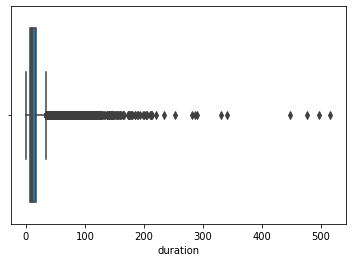

In [57]:
# New duration boxplot:

sns.boxplot(x = trips['duration'])
plt.show()

In [58]:
# Let's now repeat our descriptive statistics after having cleaned up our data:

trips.describe().T

,count,mean,std,min,25%,50%,75%,max
Trip_ID,2010310.0,1.009699e+06,582969.099294,1.00,504798.25,1009639.50,1514623.75,2019374.00
passenger_count,2010310.0,1.587727e+00,1.212694,1.00,1.00,1.00,2.00,9.00
duration,2010310.0,1.367339e+01,10.721839,0.02,6.47,10.78,17.53,516.53
trip_distance,2010310.0,2.895306e+00,3.760836,0.01,0.96,1.60,2.91,130.53
PULocationID,2010310.0,1.635273e+02,65.967609,1.00,114.00,162.00,233.00,265.00
DOLocationID,2010310.0,1.618347e+02,70.064125,1.00,112.00,162.00,234.00,265.00
fare_amount,2010310.0,1.265623e+01,11.315918,0.01,6.50,9.00,14.00,499.00
tip_amount,2010310.0,2.165132e+00,2.596467,0.00,0.00,1.86,2.86,200.00
total_amount,2010310.0,1.847892e+01,13.920692,0.31,11.00,14.16,19.80,802.32


**Updates to our descriptive statistics**
- Median of passenger count is still 1, and 75% percentile of the passenger count is still 2. 
- Average trip distance = 2.89 miles, max distance is now 130.53 miles (was 701.5) and minimum distance is now 0.01 miles.
- Average trip duration is 13.67 minutes (was 17.23 minutes before with the inaccurate extreme values) and the median is still 10.78 minutes (same as before because the amount of data removed was insignificant).
- Mean total charged is ~18.48, which is about the same as before (18.46).

## Univariate Analysis

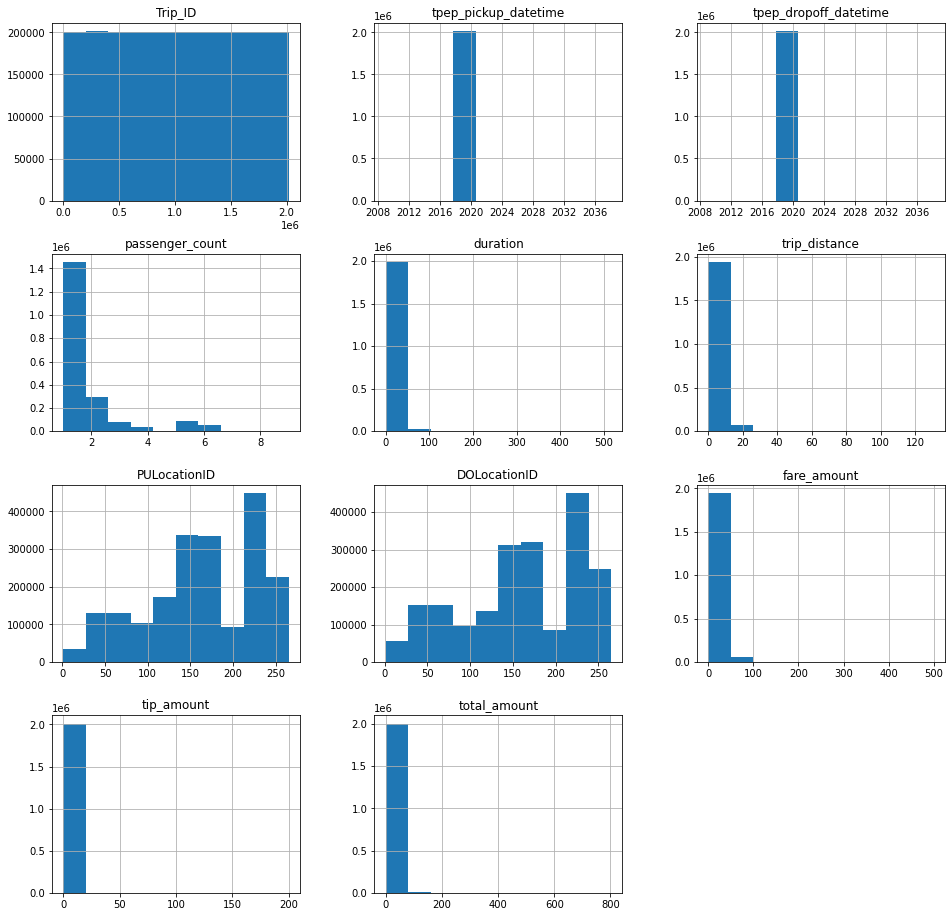

In [59]:
trips.hist(figsize=(16,16))
plt.show()

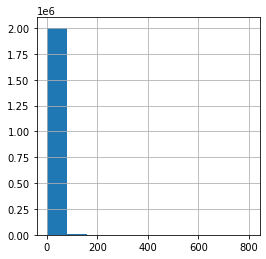

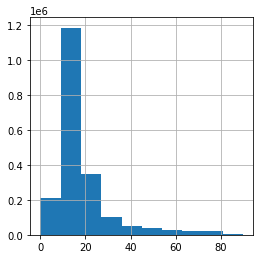

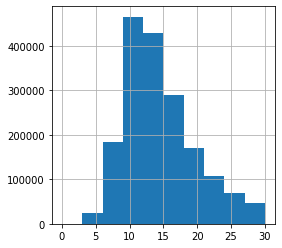

In [60]:
# Some of these charts are difficult to read because of the existence of outliers that skew the scale.

# We therefore narrow in on some categories that are relevant.

# Here it is for total_amount:

# Keeping regular scale:
trips['total_amount'].hist(figsize=(4,4))
plt.show()

# Limiting scale to range $0 - $90:
trips['total_amount'].hist(range=[0, 90], figsize=(4,4))
plt.show()

# Limiting scale to range $0 - $30 where the bulk of values are:
trips['total_amount'].hist(range=[0, 30], figsize=(4,4))
plt.show()

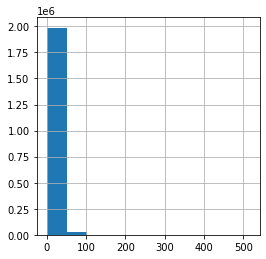

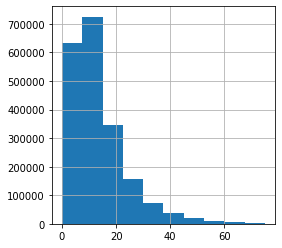

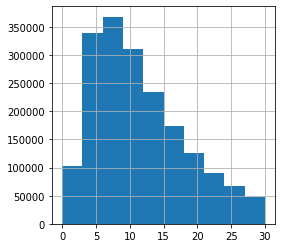

In [61]:
# For duration:

# Keeping regular scale:
trips['duration'].hist(figsize=(4,4))
plt.show()

# Limiting to range 0 - 75 minutes:
trips['duration'].hist(range=[0, 75], figsize=(4,4))
plt.show()

# Limiting to range 0 - 30 minutes where even more of the bulk of values are:
trips['duration'].hist(range=[0, 30], figsize=(4,4))
plt.show()

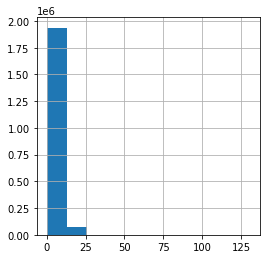

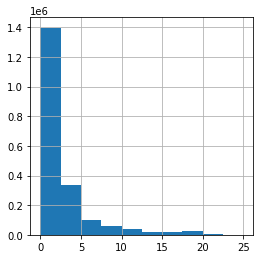

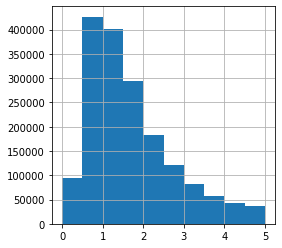

In [62]:
# For trip_distance:

# Keeping regular scale:
trips['trip_distance'].hist(figsize=(4,4))
plt.show()

# Limiting to range 0 - 25 where more of the values are:
trips['trip_distance'].hist(range=[0, 25], figsize=(4,4))
plt.show()

# Limiting to range 0 - 5 where the bulk of values are:
trips['trip_distance'].hist(range=[0, 5], figsize=(4,4))
plt.show()

The total amounts charged, trip distances and trip durations all appear right skewed.

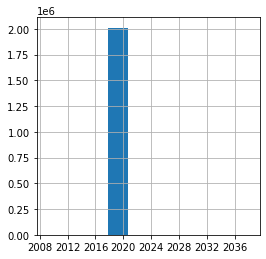

In [63]:
# Our pick up and drop off times appear to cover some values outside of our time frame of February 2019, including
# dates in 2008 and clearly incorrect data from 2038

trips['tpep_pickup_datetime'].hist(figsize=(4,4))
plt.show()

In [64]:
# Let's explore:

print(f"Min datetime: {trips['tpep_pickup_datetime'].min()} and max datetime: {trips['tpep_pickup_datetime'].max()}")

Min datetime: 2008-12-31 22:11:13 and max datetime: 2038-02-17 20:36:24


In [65]:
# There are only a few of these values, so we will remove them:

# Entries before our February 2019 time frame:
trips[trips['tpep_pickup_datetime'] < '2019-02-01 00:00:00']

,Trip_ID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,duration,trip_distance,PULocationID,DOLocationID,payment_type,fare_amount,tip_amount,total_amount,PUZone,DOZone
5,6,2019-01-31 23:58:23,2019-02-01 00:22:45,1,24.37,4.43,161,249,1,18.5,4.95,24.75,Midtown Center,West Village
59,60,2019-01-31 23:57:12,2019-02-01 00:57:37,1,60.42,6.36,261,162,2,32.0,0.00,33.30,World Trade Center,Midtown East
97,98,2019-01-31 16:07:31,2019-01-31 16:11:12,1,3.68,0.82,144,79,1,5.0,1.58,7.88,Little Italy/NoLiTa,East Village
163,164,2019-01-31 23:59:37,2019-02-01 00:17:47,1,18.17,9.77,138,63,1,28.0,5.86,35.16,LaGuardia Airport,Cypress Hills
182,183,2019-01-31 23:59:59,2019-02-01 00:28:54,1,28.92,1.43,230,90,2,12.0,0.00,13.30,Times Sq/Theatre District,Flatiron
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1243324,1243325,2008-12-31 23:30:26,2009-01-01 02:48:52,1,198.43,16.08,132,256,2,44.5,0.00,45.80,JFK Airport,Williamsburg (South Side)
1243890,1243891,2008-12-31 23:12:58,2008-12-31 23:27:52,6,14.90,1.88,50,170,2,9.5,0.00,13.30,Clinton West,Murray Hill
1244074,1244075,2008-12-31 22:11:13,2009-01-01 00:04:04,3,112.85,15.35,132,89,1,42.5,8.76,52.56,JFK Airport,Flatbush/Ditmas Park
1765117,1765118,2009-01-01 00:11:37,2009-01-01 00:25:58,1,14.35,1.41,163,236,2,9.5,0.00,13.80,Midtown North,Upper East Side North


In [66]:
# Entries after our February 2019 time frame:
trips[trips['tpep_pickup_datetime'] > '2019-02-28 23:59:59']

,Trip_ID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,duration,trip_distance,PULocationID,DOLocationID,payment_type,fare_amount,tip_amount,total_amount,PUZone,DOZone
250190,250191,2019-03-18 12:40:12,2019-03-18 12:49:18,1,9.10,1.30,238,75,1,8.0,2.20,11.00,Upper West Side North,East Harlem South
480669,480670,2019-04-11 21:17:36,2019-04-11 21:21:40,1,4.07,0.49,230,162,1,4.5,1.95,9.75,Times Sq/Theatre District,Midtown East
522265,522266,2019-09-29 13:54:19,2019-09-29 14:09:04,1,14.75,4.86,132,205,1,16.5,4.45,22.25,JFK Airport,Saint Albans
712814,712815,2019-03-03 05:56:13,2019-03-03 05:59:48,6,3.58,0.93,238,239,1,5.0,1.00,9.30,Upper West Side North,Upper West Side South
716745,716746,2019-03-24 14:50:54,2019-03-24 14:58:31,6,7.62,1.27,163,143,1,7.0,1.00,11.30,Midtown North,Lincoln Square West
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018711,2018712,2019-03-01 00:01:02,2019-03-01 00:14:26,1,13.40,1.72,68,158,1,10.0,2.76,16.56,East Chelsea,Meatpacking/West Village West
2018749,2018750,2019-03-01 00:01:19,2019-03-01 00:08:48,2,7.48,1.03,13,13,2,6.5,0.00,10.30,Battery Park City,Battery Park City
2018856,2018857,2019-03-01 00:00:47,2019-03-01 00:37:20,1,36.55,17.96,132,48,1,52.0,12.21,73.27,JFK Airport,Clinton East
2019246,2019247,2019-03-01 00:02:23,2019-03-01 00:10:25,1,8.03,1.57,140,75,2,8.0,0.00,11.80,Lenox Hill East,East Harlem South


In [67]:
# Drop:

trips.drop(trips[trips['tpep_pickup_datetime'] < '2019-02-01 00:00:00'].index, inplace=True)
trips.drop(trips[trips['tpep_pickup_datetime'] > '2019-02-28 23:59:59'].index, inplace=True)

Now let's see our histograms for date, showing fairly consistent taxi usage with what appears to be a minor weekly drop:

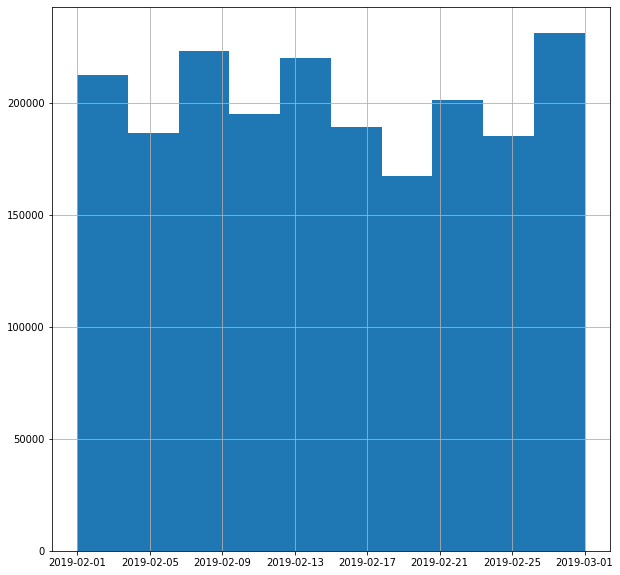

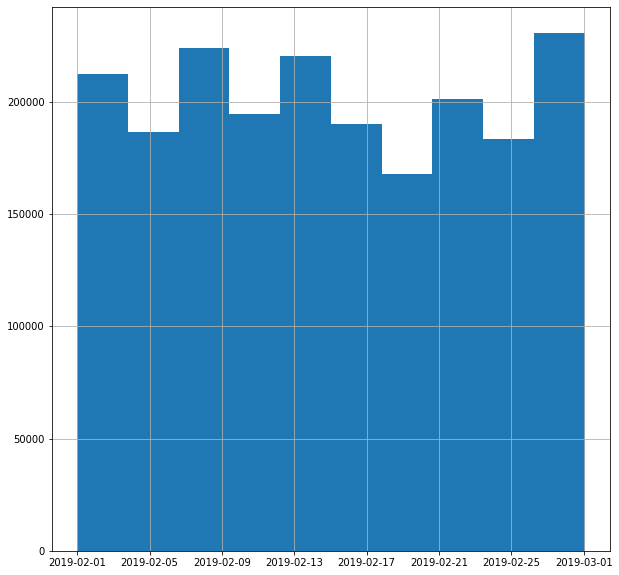

In [68]:
# Pick up time distribution:

trips['tpep_pickup_datetime'].hist(figsize=(10,10))
plt.show()

# Drop off time distribution:

trips['tpep_dropoff_datetime'].hist(figsize=(10,10))
plt.show()

### Countplot for passenger_count

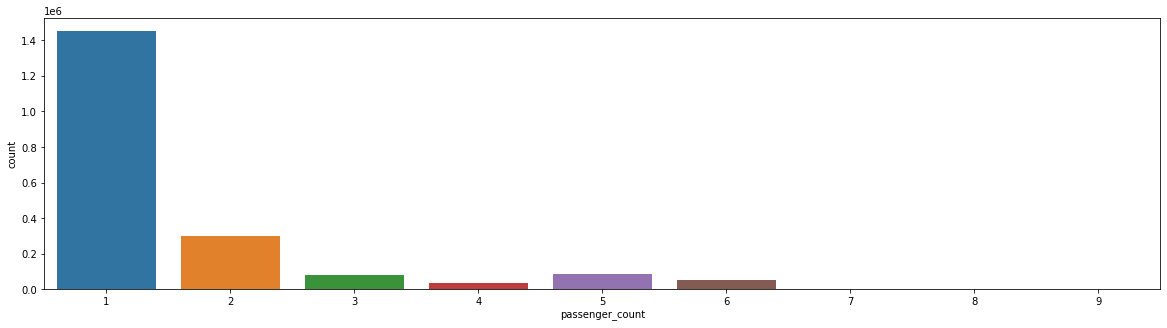

In [69]:
# The bulk of rides are taken by a single passenger.

plt.figure(figsize=(20,5))
sns.countplot(x = trips.passenger_count)
plt.show()

In [70]:
trips.passenger_count.value_counts(normalize=True)

1    0.723164
2    0.148437
5    0.043341
3    0.040946
6    0.025781
4    0.018322
7    0.000004
8    0.000003
9    0.000002
Name: passenger_count, dtype: float64

The distribution of the passenger count shows us that vast majority of passenger counts are 1.

### Countplot for Pickup and Dropoff Zones

<AxesSubplot:>

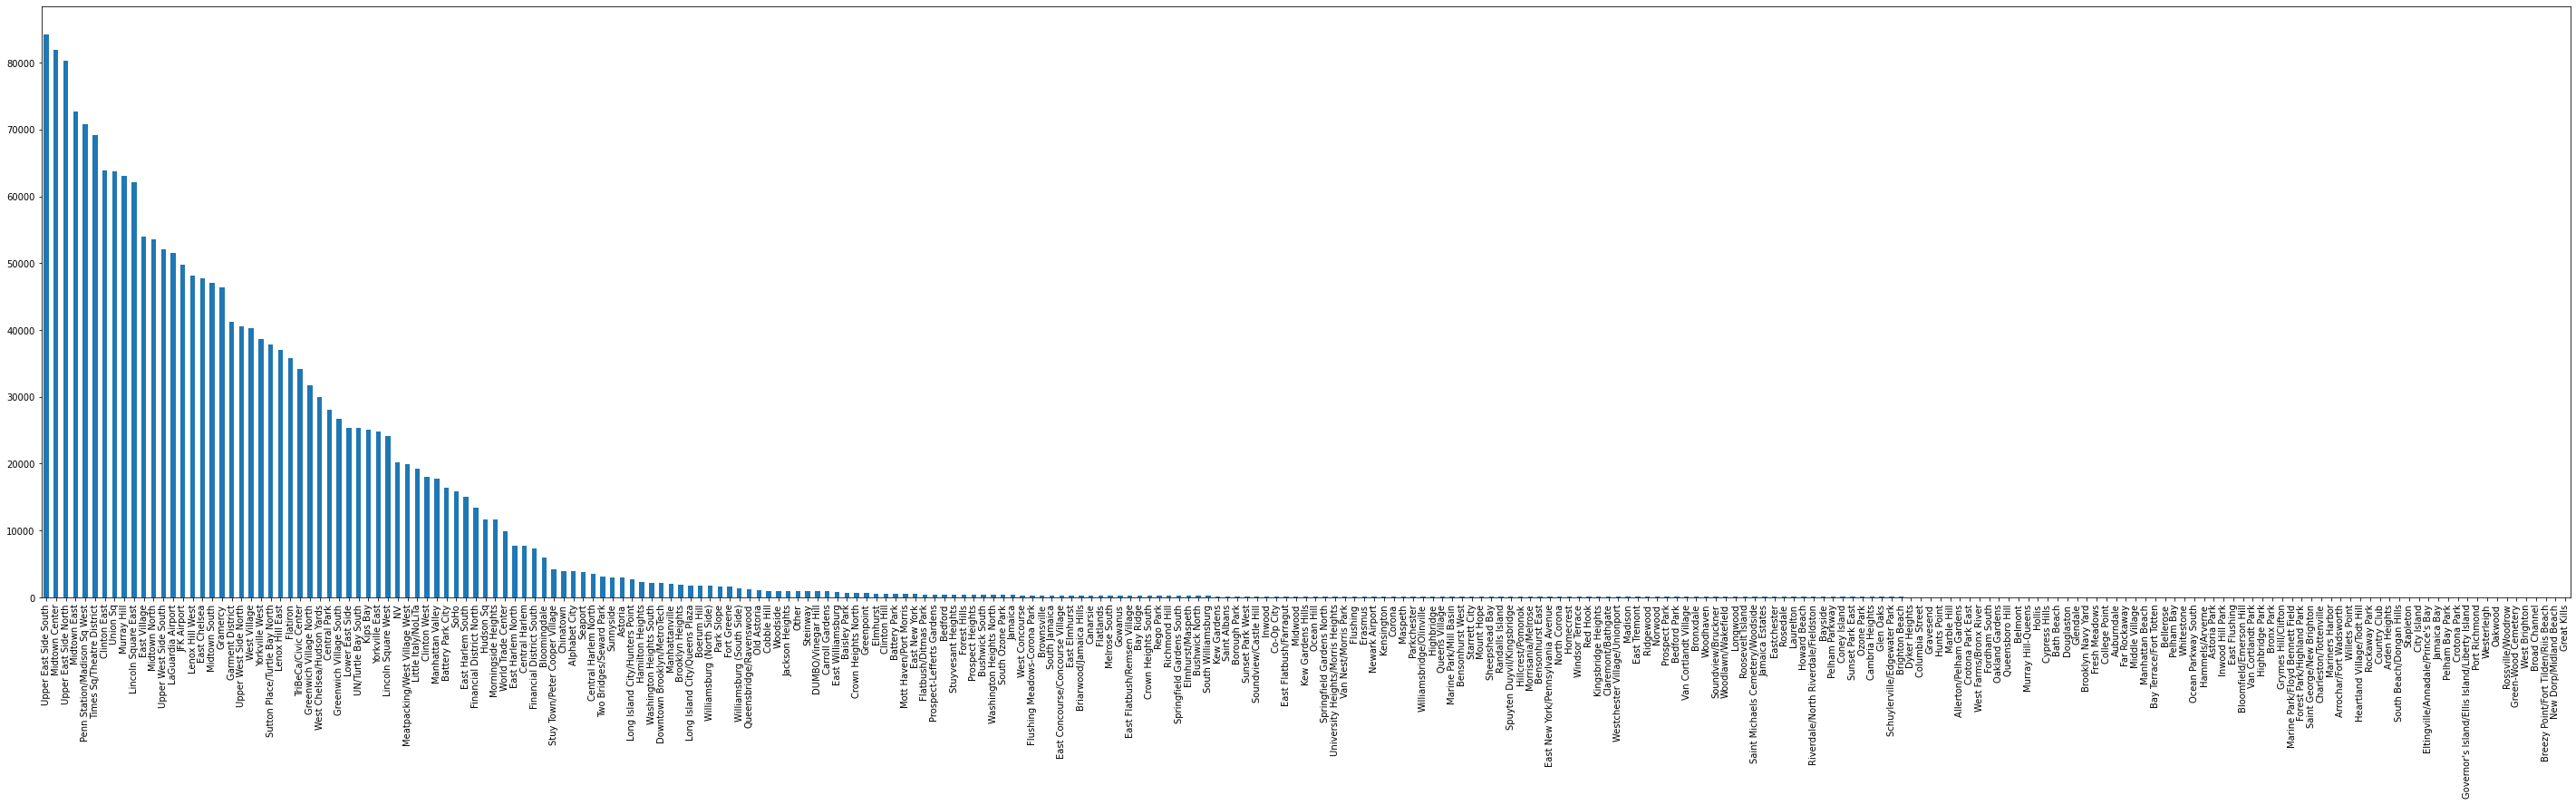

In [71]:
# Pickup neighborhoods/districts:

trips['PUZone'].value_counts().sort_values(ascending=False).plot(kind='bar' ,figsize=(50,12))

<AxesSubplot:>

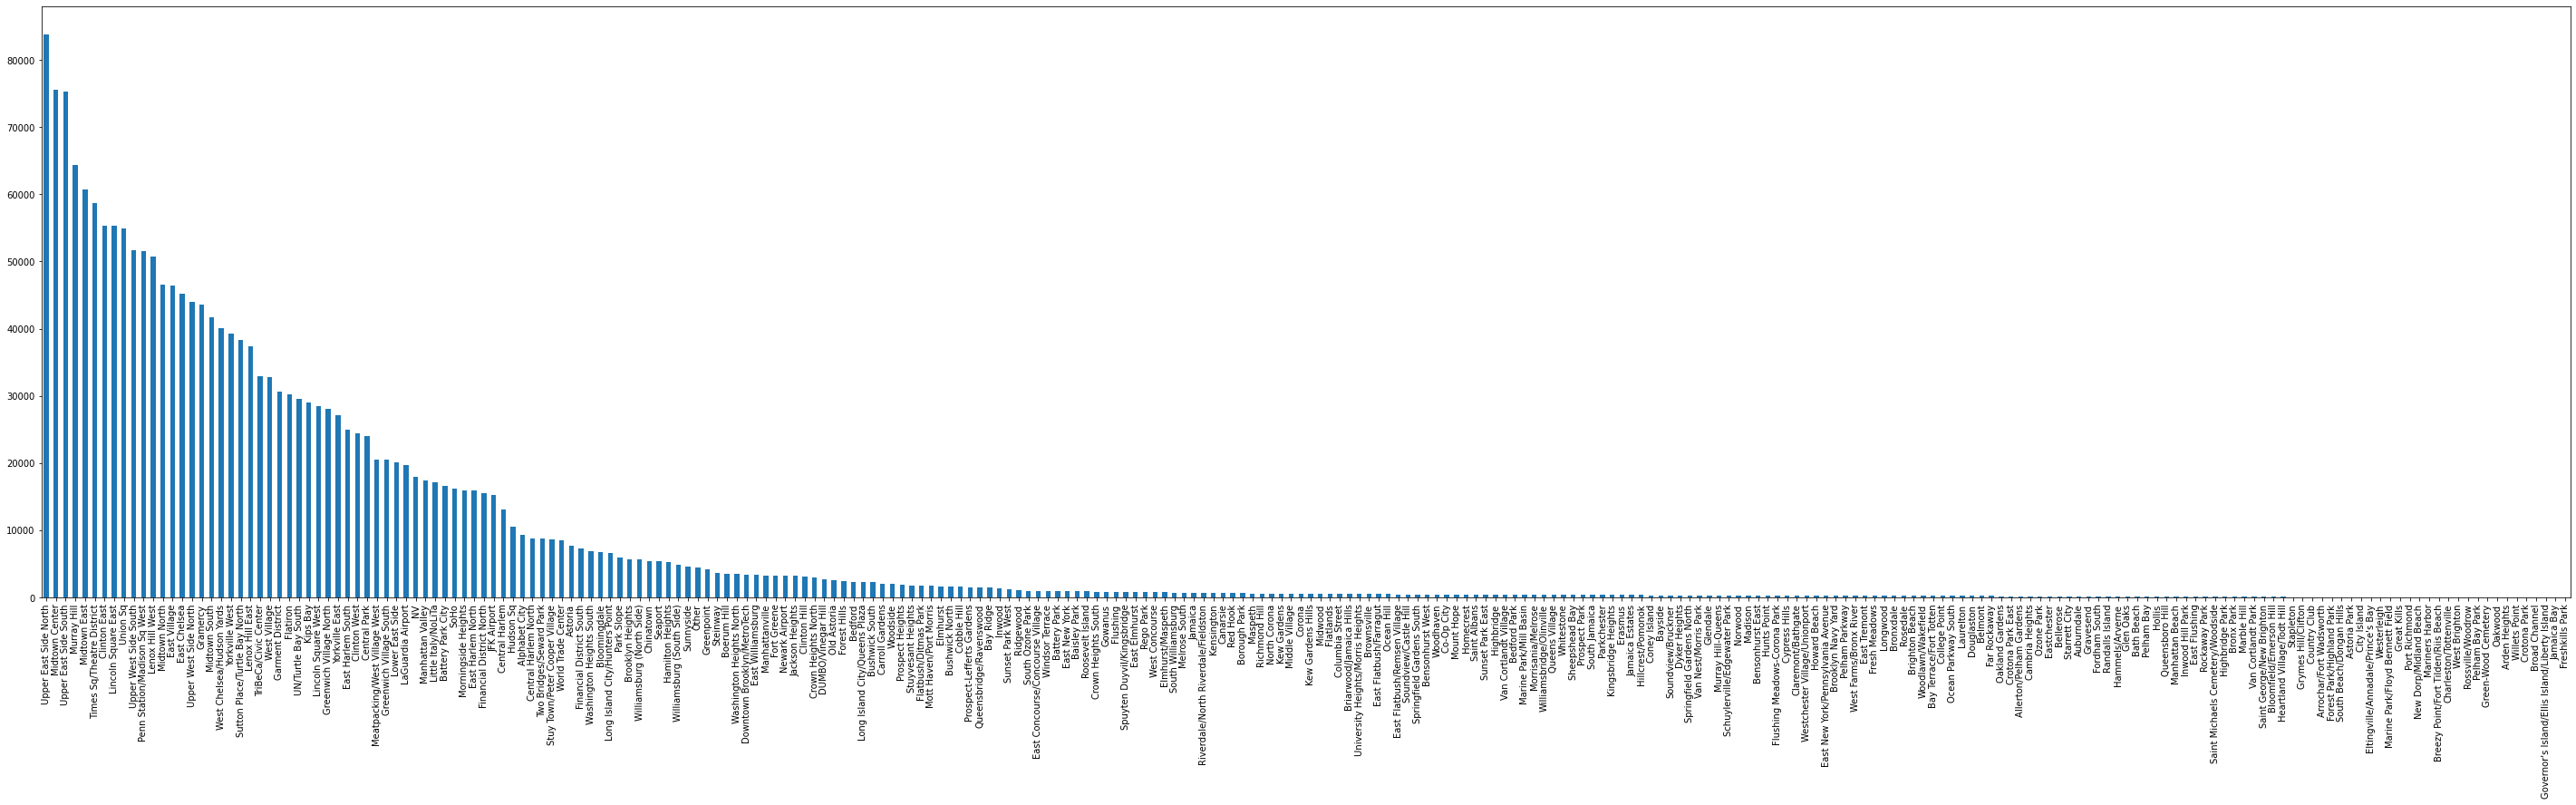

In [72]:
# Dropoff neighborhoods/districts:

trips['DOZone'].value_counts().sort_values(ascending=False).plot(kind='bar' ,figsize=(50,12))

We see that pickups and dropoffs are concentrated in a few neighborhoods such the upper east side. Public transportation authorities can consider how increasing public transportation offerings between select high-traffic volume districts may reduce the numbers of single passenger-taxi rides to improve traffic congestion, especially those high-traffic volume districts that are close by for which such a solution would be more economical to introduce.

# **Bivariate analysis**

#### Plotting a scatter plot of trip distance to trip duration

<AxesSubplot:xlabel='trip_distance', ylabel='duration'>

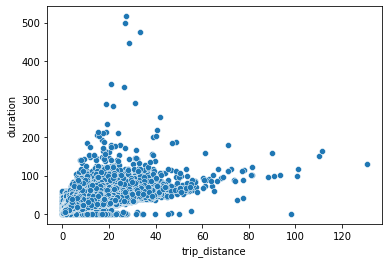

In [73]:
sns.scatterplot(x = trips['trip_distance'], y = trips['duration'])

- Trip distance is the most obvious variable that would explain duration in our dataset, and it is therefore unsurprising to see some positive correlation between trip_distance and duration.

<AxesSubplot:xlabel='passenger_count', ylabel='count'>

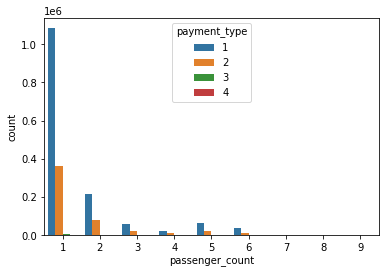

In [74]:
sns.countplot(x = trips['passenger_count'], hue=trips['payment_type'])

- We see that most passengers prefer payment type 1 (credit card) and 2 (cash), but a pattern cannot be observed as to whether payment type relates to passenger count.

## Preparing the Data for Modeling

Deep Feature Synthesis (DFS) is an automated method of performing feature engineering on relational data. Its ability to create features derived from layers of data gives the meaning of 'deep' in 'deep' feature synthesis. We will define the relational nature of our taxi dataset through its ``entities`` and ``relationships``. The three entities in this data are:
* trips 
* pickup_neighborhoods
* dropoff_neighborhoods

This data has the following relationships
* pickup_neighborhoods (parent) - trips (child): a single neighborhood can have multiple trips that start in it, meaning pickup_neighborhoods is the parent entity and trips is the child entity.
* dropoff_neighborhoods is likewise a parent to trips, the child entity.

In [75]:
# We first make make pickup and dropoff dataframes that we will relate to the trips dataframe:
pickup_zones = zones.drop(columns=['Borough','service_zone'])
dropoff_zones = zones.drop(columns=['Borough','service_zone'])

In [76]:
# As noted earlier, the na values in the zones dataframes are for zone=265, which appears to be outside of the NY
# taxi zones, so we replace with 'Other' here as we did earlier in the trips dataframe
pickup_zones['Zone'].fillna('Other', inplace=True)
dropoff_zones['Zone'].fillna('Other', inplace=True)

In [77]:
# Confirming that our null values have been addressed:

pickup_zones.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 265 entries, 0 to 264
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   LocationID  265 non-null    int64 
 1   Zone        265 non-null    object
dtypes: int64(1), object(1)
memory usage: 4.3+ KB


In [78]:
pickup_zones.head()

,LocationID,Zone
0,1,Newark Airport
1,2,Jamaica Bay
2,3,Allerton/Pelham Gardens
3,4,Alphabet City
4,5,Arden Heights


We need to transform any of our categorical data into numeric data for processing. In our original trips dataframe, rendering the categories in our ``PUZone`` and ``DOZone`` columns numerically would result in numbers ranging from 1 to ~260 (the number of zones). However, we don't want the ML models to incorrectly assume a larger number represents a greater magnitude or significance, e.g., by taking a zone rendered as the number 23 to be greater than a zone rendered as the number 4.

Therefore we will use ``get_dummies`` to separate out all of the zone categories as their own columns. A trip being linked to a specific pick up or drop off zone will be noted as a 0 or 1 instead. We will apply get_dummies on our pickup_zones and dropoff_zones dataframes rather than our trips dataframe (the dataframes will all be combined when we create our feature matrix).

In [79]:
# Turning the categorical information contained in column "Zone" into numeric with get_dummies:

pickup_zones = pd.get_dummies(pickup_zones, columns=['Zone'], prefix = "PU_Loc = ", prefix_sep = "")
dropoff_zones = pd.get_dummies(dropoff_zones, columns=['Zone'], prefix = "DO_Loc = ", prefix_sep = "")

In [80]:
pickup_zones.head()

,LocationID,PU_Loc = Allerton/Pelham Gardens,PU_Loc = Alphabet City,PU_Loc = Arden Heights,PU_Loc = Arrochar/Fort Wadsworth,PU_Loc = Astoria,PU_Loc = Astoria Park,PU_Loc = Auburndale,PU_Loc = Baisley Park,PU_Loc = Bath Beach,...,PU_Loc = Williamsbridge/Olinville,PU_Loc = Williamsburg (North Side),PU_Loc = Williamsburg (South Side),PU_Loc = Windsor Terrace,PU_Loc = Woodhaven,PU_Loc = Woodlawn/Wakefield,PU_Loc = Woodside,PU_Loc = World Trade Center,PU_Loc = Yorkville East,PU_Loc = Yorkville West
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [81]:
dropoff_zones.head()

,LocationID,DO_Loc = Allerton/Pelham Gardens,DO_Loc = Alphabet City,DO_Loc = Arden Heights,DO_Loc = Arrochar/Fort Wadsworth,DO_Loc = Astoria,DO_Loc = Astoria Park,DO_Loc = Auburndale,DO_Loc = Baisley Park,DO_Loc = Bath Beach,...,DO_Loc = Williamsbridge/Olinville,DO_Loc = Williamsburg (North Side),DO_Loc = Williamsburg (South Side),DO_Loc = Windsor Terrace,DO_Loc = Woodhaven,DO_Loc = Woodlawn/Wakefield,DO_Loc = Woodside,DO_Loc = World Trade Center,DO_Loc = Yorkville East,DO_Loc = Yorkville West
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Let's now use get_dummies on payment_type, also a categorical column, so that one payment type is not assumed to be greater than another.

In [82]:
# Applying get_dummies on payment_type in our trips dataframe. See the final columns for the appended payment columns

trips = pd.get_dummies(data=trips, columns=['payment_type'])

trips.head()

,Trip_ID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,duration,trip_distance,PULocationID,DOLocationID,fare_amount,tip_amount,total_amount,PUZone,DOZone,payment_type_1,payment_type_2,payment_type_3,payment_type_4
0,1,2019-02-01 00:45:38,2019-02-01 00:51:10,1,5.53,0.8,95,95,5.5,0.00,6.80,Forest Hills,Forest Hills,0,1,0,0
1,2,2019-02-01 00:38:02,2019-02-01 00:40:57,1,2.92,0.8,229,141,4.5,0.00,5.80,Sutton Place/Turtle Bay North,Lenox Hill West,0,1,0,0
2,3,2019-02-01 00:06:49,2019-02-01 00:10:34,1,3.75,0.9,75,41,5.0,0.00,6.30,East Harlem South,Central Harlem,0,1,0,0
3,4,2019-02-01 00:15:53,2019-02-01 00:25:41,2,9.80,1.8,68,246,9.0,2.05,12.35,East Chelsea,West Chelsea/Hudson Yards,1,0,0,0
4,5,2019-02-01 00:28:54,2019-02-01 00:33:51,1,4.95,0.8,246,68,5.5,2.00,8.80,West Chelsea/Hudson Yards,East Chelsea,1,0,0,0


### Defining entities and relationships for Deep Feature Synthesis

In [83]:
entities = {"trips":(trips, "Trip_ID", 'tpep_pickup_datetime'),
              "pickup_zones":(pickup_zones, "LocationID"),
              "dropoff_zones":(dropoff_zones, "LocationID")}

relationships = [("pickup_zones", "LocationID", "trips", "PULocationID"),
                 ("dropoff_zones", "LocationID", "trips", "DOLocationID")]

We also indicate a cutoff time which will apply to every instance of our target_entity, in this case, each trip recorded in ``trips``. This cut off time refers to the last time data can be used for calculating features by DFS. This constraint is out of a practical consideration. We want to be able to predict our duration **before** the trip begins, and as such, the cutoff time should be set to our pickup time. This means that the model will consider data before a trip was made in order to predict that trip, rather then apply what it learns from that trip's data on that trip, which will not be a possibility in a real world application.

For the purposes of the case study, we also choose to only select trips after February 15th, 2019.

Refer to this source for more information:
https://docs.featuretools.com/en/v0.16.0/automated_feature_engineering/handling_time.html

From documentation, the cutoff_time:
Can either be a DataFrame or a single value. If a DataFrame is passed the instance ids for which to calculate features must be in a column with the same name as the target dataframe index or a column named instance_id. The cutoff time values in the DataFrame must be in a column with the same name as the target dataframe time index or a column named time. If the DataFrame has more than two columns, any additional columns will be added to the resulting feature matrix. If a single value is passed, this value will be used for all instances.
See: https://featuretools.alteryx.com/en/stable/generated/featuretools.calculate_feature_matrix.html

In [84]:
# Creating a function to preview first five rows. 
def preview(df, n=5):
    """return n rows that have fewest number of nulls"""
    order = df.isnull().sum(axis=1).sort_values().head(n).index
    return df.loc[order]

In [85]:
cutoff_time = trips[['Trip_ID', 'tpep_pickup_datetime']]
cutoff_time = cutoff_time[cutoff_time['tpep_pickup_datetime'] > "2019-02-15 00:00:00"]
preview(cutoff_time, 10)

,Trip_ID,tpep_pickup_datetime
250188,250189,2019-02-25 04:24:02
1693334,1693335,2019-02-24 15:37:16
1693335,1693336,2019-02-24 15:48:54
1693336,1693337,2019-02-24 15:58:43
1693337,1693338,2019-02-24 15:34:40
1693338,1693339,2019-02-24 15:57:22
1693339,1693340,2019-02-24 15:38:38
1693340,1693341,2019-02-24 15:02:56
1693341,1693342,2019-02-24 15:24:13
1693342,1693343,2019-02-24 15:29:23


### Create baseline features using Deep Feature Synthesis

Instead of manually creating features, such as identifying the month of the pickup datetime, we can let Deep Feature Synthesis come up with them automatically. It does this in the following way: 
* DFS interprets the variable types of the columns, e.g categorical, numeric and others 
* Matches the columns to the specific primitives that can be applied to that variable type
* It creates features based on these matches

**Creating transform features using transform primitives**

As noted earlier, features fall into a couple major categories, including ``identity`` features (which are already found in the data), ``transform`` features, and ``aggregate`` features. In featureools, we can create transform features by specifying ``transform`` primitives. Here is a ``transform`` primitive called ``weekend`` that applies to any ``datetime`` column in the data. It assesses if the entry is a ``weekend`` and returns a boolean. 

In our data, we have two ``datetime`` columns taht this primitive will apply to: ``tpep_pickup_datetime`` and ``tpep_dropoff_datetime``, however we will set our feature settings to ignore ``tpep_dropoff_datetime`` for the obvious reason that an exact dropoff date/time will not be available in a real life setting and shouldn't be considered in a prediction.

Note that we will ignore several other variables from the trips dataframe, including those related to amount charged (as that information will not be available for predicting a trip's duration before hand), and information that is redundant (the location data is already recorded in the pickup_zones and dropoff_zones dataframes)

In [86]:
trans_primitives = [IsWeekend]

features = ft.dfs(entities=entities,
                  relationships=relationships,
                  target_entity="trips",
                  trans_primitives=trans_primitives,
                  agg_primitives=[],
                  ignore_variables={"trips": ["PULocationID", "DOLocationID", "tpep_dropoff_datetime",
                                              "PUZone", "DOZone", "fare_amount", "tip_amount", "total_amount"]},
                  features_only=True)

<p>Here are the features created:</p>

In [87]:
print ("Number of features = %d" % len(features))
features

Number of features = 532


[<Feature: passenger_count>,
 <Feature: duration>,
 <Feature: trip_distance>,
 <Feature: payment_type_1>,
 <Feature: payment_type_2>,
 <Feature: payment_type_3>,
 <Feature: payment_type_4>,
 <Feature: IS_WEEKEND(tpep_pickup_datetime)>,
 <Feature: pickup_zones.PU_Loc = Allerton/Pelham Gardens>,
 <Feature: pickup_zones.PU_Loc = Alphabet City>,
 <Feature: pickup_zones.PU_Loc = Arden Heights>,
 <Feature: pickup_zones.PU_Loc = Arrochar/Fort Wadsworth>,
 <Feature: pickup_zones.PU_Loc = Astoria>,
 <Feature: pickup_zones.PU_Loc = Astoria Park>,
 <Feature: pickup_zones.PU_Loc = Auburndale>,
 <Feature: pickup_zones.PU_Loc = Baisley Park>,
 <Feature: pickup_zones.PU_Loc = Bath Beach>,
 <Feature: pickup_zones.PU_Loc = Battery Park>,
 <Feature: pickup_zones.PU_Loc = Battery Park City>,
 <Feature: pickup_zones.PU_Loc = Bay Ridge>,
 <Feature: pickup_zones.PU_Loc = Bay Terrace/Fort Totten>,
 <Feature: pickup_zones.PU_Loc = Bayside>,
 <Feature: pickup_zones.PU_Loc = Bedford>,
 <Feature: pickup_zones.PU

Of the 532 features, only 1 is the new transform feature ('IS_WEEKEND'), the rest are the features that were already present in the data.

**Compute features and define feature matrix**

In [88]:
# Function to compute our features and return the feature_matrix which includes our computed features. Note our time
# cutoff parameters below:
def compute_features(features, cutoff_time):
    feature_matrix = ft.calculate_feature_matrix(features,
                                                 cutoff_time=cutoff_time,
                                                 approximate='15d', # I don't fully understand
                                                 verbose=True, # Prints progress info
                                                 entities=entities,
                                                 relationships=relationships)
    feature_matrix, features = ft.encode_features(feature_matrix, features,
                                                  to_encode=["PULocationID", "DOLocationID"],
                                                  include_unknown=False)
    return feature_matrix

In [89]:
# Compute our new feature matrix:

feature_matrix1 = compute_features(features, cutoff_time)

Elapsed: 00:27 | Progress: 100%|████████████████████████████████████████████████


In [90]:
# Let's see the output:
preview(feature_matrix1, 15)

,passenger_count,duration,trip_distance,payment_type_1,payment_type_2,payment_type_3,payment_type_4,IS_WEEKEND(tpep_pickup_datetime),pickup_zones.PU_Loc = Allerton/Pelham Gardens,pickup_zones.PU_Loc = Alphabet City,...,dropoff_zones.DO_Loc = Williamsbridge/Olinville,dropoff_zones.DO_Loc = Williamsburg (North Side),dropoff_zones.DO_Loc = Williamsburg (South Side),dropoff_zones.DO_Loc = Windsor Terrace,dropoff_zones.DO_Loc = Woodhaven,dropoff_zones.DO_Loc = Woodlawn/Wakefield,dropoff_zones.DO_Loc = Woodside,dropoff_zones.DO_Loc = World Trade Center,dropoff_zones.DO_Loc = Yorkville East,dropoff_zones.DO_Loc = Yorkville West
Trip_ID,,,,,,,,,,,,,,,,,,,,,
250189,1,8.43,1.51,0,1,0,0,False,0,0,...,0,0,0,0,0,0,0,0,0,0
1693335,2,10.25,1.10,1,0,0,0,True,0,0,...,0,0,0,0,0,0,0,0,0,0
1693336,4,7.83,1.00,0,1,0,0,True,0,0,...,0,0,0,0,0,0,0,0,0,0
1693337,1,3.93,0.70,1,0,0,0,True,0,0,...,0,0,0,0,0,0,0,0,0,0
1693338,1,5.23,0.92,0,1,0,0,True,0,0,...,0,0,0,0,0,0,0,0,0,0
1693339,1,8.57,1.10,1,0,0,0,True,0,0,...,0,0,0,0,0,0,0,0,0,0
1693340,1,9.15,1.31,1,0,0,0,True,0,0,...,0,0,0,0,0,0,0,0,0,0
1693341,3,6.77,0.88,0,1,0,0,True,0,0,...,0,0,0,0,0,0,0,0,0,0
1693342,2,10.32,1.60,1,0,0,0,True,0,0,...,0,0,0,0,0,0,0,0,0,0


In [91]:
# Let's confirm the case of 'Trip_ID' == 1693354, to see
# that '1' is indeed set for 'dropoff_neighborhoods.DO_Loc = Yorkville West' as we would expect:

feature_matrix1.loc[1693354]

passenger_count                                 1
duration                                     2.42
trip_distance                                 0.5
payment_type_1                                  0
payment_type_2                                  1
                                             ... 
dropoff_zones.DO_Loc = Woodlawn/Wakefield       0
dropoff_zones.DO_Loc = Woodside                 0
dropoff_zones.DO_Loc = World Trade Center       0
dropoff_zones.DO_Loc = Yorkville East           0
dropoff_zones.DO_Loc = Yorkville West           1
Name: 1693354, Length: 532, dtype: object

In [92]:
# The data looks accurate. The recorded pickup/drop off data is also given as TRUE for
# the IS_WEEKEND feature and this is correct (2/24/2019 was a Sunday):

trips[trips['Trip_ID']==1693354]

,Trip_ID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,duration,trip_distance,PULocationID,DOLocationID,fare_amount,tip_amount,total_amount,PUZone,DOZone,payment_type_1,payment_type_2,payment_type_3,payment_type_4
1693353,1693354,2019-02-24 15:56:24,2019-02-24 15:58:49,1,2.42,0.5,236,263,4.0,0.0,7.3,Upper East Side North,Yorkville West,0,1,0,0


In [93]:
feature_matrix1.shape

(973927, 532)

Note that this is less than half of our previous number of entries, which was 2010151. The size used for the feature matrix went down because we decided to limit our cut off times to half of the month (dates in February AFTER february 15th, 2019)

# Building Our Models

We now separate the data into a portion for ``training`` (80% in this case) and a portion for ``testing`` (20%). 
We will train the model using ``Linear Regression``, ``Decision Tree``, and ``Random Forest``

### Splitting the data into X and y

In [94]:
X = feature_matrix1.loc[:, feature_matrix1.columns != 'duration']
y = feature_matrix1['duration']

In [95]:
X

,passenger_count,trip_distance,payment_type_1,payment_type_2,payment_type_3,payment_type_4,IS_WEEKEND(tpep_pickup_datetime),pickup_zones.PU_Loc = Allerton/Pelham Gardens,pickup_zones.PU_Loc = Alphabet City,pickup_zones.PU_Loc = Arden Heights,...,dropoff_zones.DO_Loc = Williamsbridge/Olinville,dropoff_zones.DO_Loc = Williamsburg (North Side),dropoff_zones.DO_Loc = Williamsburg (South Side),dropoff_zones.DO_Loc = Windsor Terrace,dropoff_zones.DO_Loc = Woodhaven,dropoff_zones.DO_Loc = Woodlawn/Wakefield,dropoff_zones.DO_Loc = Woodside,dropoff_zones.DO_Loc = World Trade Center,dropoff_zones.DO_Loc = Yorkville East,dropoff_zones.DO_Loc = Yorkville West
Trip_ID,,,,,,,,,,,,,,,,,,,,,
250189,1,1.51,0,1,0,0,False,0,0,0,...,0,0,0,0,0,0,0,0,0,0
476623,1,0.52,1,0,0,0,False,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1038008,1,0.93,1,0,0,0,False,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1038552,6,10.10,1,0,0,0,False,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1039204,3,1.52,0,1,0,0,False,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019370,1,1.50,1,0,0,0,False,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2019371,1,3.10,1,0,0,0,False,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2019372,1,1.30,0,1,0,0,False,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [96]:
y

Trip_ID
250189      8.43
476623      3.38
1038008     3.93
1038552    48.95
1039204     6.07
           ...  
2019370     8.68
2019371     9.85
2019372    10.03
2019373    38.98
2019374     6.18
Name: duration, Length: 973927, dtype: float64

### Scaling our data
Because some of our independent variables are in different magnitudes, our models may incorrectly give weight to some variables over others by virtue of this difference. So we will scale relevant non-categorical values with the StandardScaler class. The scaler will ultimately make the standard deviation = 1, and mean = 0 for our values. We will apply this to our passenger_count and trip_distance features.

In [97]:
from sklearn.preprocessing import StandardScaler

In [98]:
# Scaling the numeric data in our X data

scaler = StandardScaler()

X_scaled = X
X_scaled[['passenger_count','trip_distance']] = scaler.fit_transform(X_scaled[['passenger_count','trip_distance']])

X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

X_scaled

,passenger_count,trip_distance,payment_type_1,payment_type_2,payment_type_3,payment_type_4,IS_WEEKEND(tpep_pickup_datetime),pickup_zones.PU_Loc = Allerton/Pelham Gardens,pickup_zones.PU_Loc = Alphabet City,pickup_zones.PU_Loc = Arden Heights,...,dropoff_zones.DO_Loc = Williamsbridge/Olinville,dropoff_zones.DO_Loc = Williamsburg (North Side),dropoff_zones.DO_Loc = Williamsburg (South Side),dropoff_zones.DO_Loc = Windsor Terrace,dropoff_zones.DO_Loc = Woodhaven,dropoff_zones.DO_Loc = Woodlawn/Wakefield,dropoff_zones.DO_Loc = Woodside,dropoff_zones.DO_Loc = World Trade Center,dropoff_zones.DO_Loc = Yorkville East,dropoff_zones.DO_Loc = Yorkville West
Trip_ID,,,,,,,,,,,,,,,,,,,,,
250189,-0.488500,-0.376749,0,1,0,0,False,0,0,0,...,0,0,0,0,0,0,0,0,0,0
476623,-0.488500,-0.633641,1,0,0,0,False,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1038008,-0.488500,-0.527251,1,0,0,0,False,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1038552,3.633238,1.852236,1,0,0,0,False,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1039204,1.160195,-0.374155,0,1,0,0,False,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019370,-0.488500,-0.379344,1,0,0,0,False,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2019371,-0.488500,0.035833,1,0,0,0,False,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2019372,-0.488500,-0.431241,0,1,0,0,False,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Splitting Our Data into Train and Test (80/20 split)

In [99]:
from sklearn.model_selection import train_test_split

In [100]:
# We run the train_test_split function from sklearn:

X_train, X_test, y_train, y_test = train_test_split(X_scaled,y,test_size=0.2, random_state=10)

In [101]:
# Confirm that it split properly. X_train should be 80% of the total data size (so 80% of 973888), which it is:

len(X_train)

779141

In [102]:
# X_test should be 20% of the total data size (so 20% of 973888), which it is:

len(X_test)

194786

In [103]:
# If we see X_train below, we'll see that they are now randomly ordered as well (see Trip_ID numbers):

X_train

,passenger_count,trip_distance,payment_type_1,payment_type_2,payment_type_3,payment_type_4,IS_WEEKEND(tpep_pickup_datetime),pickup_zones.PU_Loc = Allerton/Pelham Gardens,pickup_zones.PU_Loc = Alphabet City,pickup_zones.PU_Loc = Arden Heights,...,dropoff_zones.DO_Loc = Williamsbridge/Olinville,dropoff_zones.DO_Loc = Williamsburg (North Side),dropoff_zones.DO_Loc = Williamsburg (South Side),dropoff_zones.DO_Loc = Windsor Terrace,dropoff_zones.DO_Loc = Woodhaven,dropoff_zones.DO_Loc = Woodlawn/Wakefield,dropoff_zones.DO_Loc = Woodside,dropoff_zones.DO_Loc = World Trade Center,dropoff_zones.DO_Loc = Yorkville East,dropoff_zones.DO_Loc = Yorkville West
Trip_ID,,,,,,,,,,,,,,,,,,,,,
1283807,-0.488500,-0.532441,1,0,0,0,False,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1343600,3.633238,0.303104,1,0,0,0,False,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1771043,0.335848,-0.488328,0,1,0,0,False,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1755695,-0.488500,-0.221058,0,1,0,0,False,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1347438,1.160195,-0.244412,1,0,0,0,False,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1661756,1.160195,-0.418267,1,0,0,0,True,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1486816,-0.488500,-0.716676,0,1,0,0,False,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1926202,-0.488500,-0.298904,1,0,0,0,False,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Defining functions to check the performance of the model. 

In [104]:
# RMSE (root mean square deviation)
def rmse(predictions, targets):
    return np.sqrt(((targets - predictions) ** 2).mean())

# MAE (mean absolute error)
def mae(predictions, targets):
    return np.mean(np.abs((targets - predictions)))


# Model Performance on test and train data
def model_performance(model, x_train, x_test, y_train,y_test):

    # Insample Prediction
    y_pred_train = model.predict(x_train)
    y_observed_train = y_train

    # Prediction on test data
    y_pred_test = model.predict(x_test)
    y_observed_test = y_test

    print(
        pd.DataFrame(
            {
                "Data": ["Train", "Test"],
                'RSquared':
                    [r2_score(y_observed_train,y_pred_train),
                    r2_score(y_observed_test,y_pred_test )
                    ],
                "RMSE": [
                    rmse(y_pred_train, y_observed_train),
                    rmse(y_pred_test, y_observed_test),
                ],
                "MAE": [
                    mae(y_pred_train, y_observed_train),
                    mae(y_pred_test, y_observed_test),
                ],
            }
        )
    )

#### Building Our First Linear Regression Model

In [105]:
lr1=LinearRegression()

# Fitting the model:
lr1.fit(X_train,y_train)

LinearRegression()

#### Check the performance of the model

In [106]:
model_performance(lr1, X_train, X_test, y_train, y_test)

    Data      RSquared          RMSE            MAE
0  Train  6.913203e-01  6.004204e+00       4.087635
1   Test -6.435891e+12  2.733855e+07  134640.596459


The linear regression model clearly does not fit as we end up with an extreme negative R-Squared result in the test data. The existence of many unnecessary variables can negatively affect the multiple regression equation, and in our case, we have 531 independent variables(!). We will later reduce the number of features to see if this fixes our linear regression model, using Principal Component Analysis and also by doing a simple linear regression using only the single independent variable of trip_distance, but in the mean time, we will first try alternative models to see if we have a better fit using our large feature set.

#### Building a Decision Tree

In [107]:
dt=DecisionTreeRegressor()

# fitting the model

dt.fit(X_train,y_train)

DecisionTreeRegressor()

#### Check the performance of the model

In [108]:
model_performance(dt, X_train, X_test,y_train,y_test)

    Data  RSquared      RMSE       MAE
0  Train  0.961199  2.128754  0.969836
1   Test  0.612667  6.706765  4.222617


The model is providing more reasonable results then our linear regression model, but the the model is very strongly overfitting, as there is a .35 difference in the R-Squared values in the train and test. Let's see if we can improve it further by building a pruned decision tree.

#### Building a Pruned Decision Tree

In [109]:
# We use a max_depth=7 (the deeper the tree, the more splits in the tree that captures more information from our data)
dt_pruned=DecisionTreeRegressor(max_depth=7)

# fitting the model
dt_pruned.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=7)

#### Check the performance of the model

In [110]:
model_performance(dt_pruned, X_train, X_test,y_train,y_test)

    Data  RSquared      RMSE       MAE
0  Train  0.725988  5.657003  3.721629
1   Test  0.730615  5.593170  3.713478


The pruned decision tree offers us a much better model for predicting our trip duration. The R-Squared values appear to be almost the same between our train and test data which means the model is a good fit. Our RSquared value of 0.72 and 0.73 for the Train and Test respectively is good. We also see a significant improvement in our results on the test data in this model when compared to our base decision tree (the previous model).

#### Building a Random Forest

In [111]:
# n_estimators refers to the number of 'trees' in our 'forest' (set to 80), and our max_depth=7

rf=RandomForestRegressor(n_estimators=80,max_depth=7)

In [112]:
# fitting the model
rf.fit(X_train,y_train)

RandomForestRegressor(max_depth=7, n_estimators=80)

#### Check the performance of the model

In [113]:
model_performance(rf, X_train, X_test,y_train,y_test)

    Data  RSquared      RMSE       MAE
0  Train  0.730243  5.612909  3.700281
1   Test  0.733689  5.561161  3.693207


With the random forest regressor (set to 80 trees and a max depth of 7), we see that our R-Squared score has slightly improved over our pruned decision tree. The model seems to be the best fitting of all the models looked at, and has the best performance.

# Adding More Transform Primitives and Redoing Our Models

* We add additional ``datetime``-related primitives to see if they improve our models, including primitives that define minute, hour, day, month, and whether the event is a weekday. We ignore the drop_off datetime variable as that will not be available for real life predictions.

In [114]:
# Now instead of just IsWeekend, we add the following transform primitives (which will apply on our datetime columns):
trans_primitives = [Minute, Hour, Day, Month, Weekday, IsWeekend]

features = ft.dfs(entities=entities,
                  relationships=relationships,
                  target_entity="trips",
                  trans_primitives=trans_primitives,
                  agg_primitives=[],
                  ignore_variables={"trips": ["PULocationID", "DOLocationID", "tpep_dropoff_datetime",
                                              "PUZone", "DOZone", "fare_amount", "tip_amount", "total_amount"]},
                  features_only=True)

In [115]:
print ("Number of features: %d" % len(features))
features

Number of features: 537


[<Feature: passenger_count>,
 <Feature: duration>,
 <Feature: trip_distance>,
 <Feature: payment_type_1>,
 <Feature: payment_type_2>,
 <Feature: payment_type_3>,
 <Feature: payment_type_4>,
 <Feature: DAY(tpep_pickup_datetime)>,
 <Feature: HOUR(tpep_pickup_datetime)>,
 <Feature: IS_WEEKEND(tpep_pickup_datetime)>,
 <Feature: MINUTE(tpep_pickup_datetime)>,
 <Feature: MONTH(tpep_pickup_datetime)>,
 <Feature: WEEKDAY(tpep_pickup_datetime)>,
 <Feature: pickup_zones.PU_Loc = Allerton/Pelham Gardens>,
 <Feature: pickup_zones.PU_Loc = Alphabet City>,
 <Feature: pickup_zones.PU_Loc = Arden Heights>,
 <Feature: pickup_zones.PU_Loc = Arrochar/Fort Wadsworth>,
 <Feature: pickup_zones.PU_Loc = Astoria>,
 <Feature: pickup_zones.PU_Loc = Astoria Park>,
 <Feature: pickup_zones.PU_Loc = Auburndale>,
 <Feature: pickup_zones.PU_Loc = Baisley Park>,
 <Feature: pickup_zones.PU_Loc = Bath Beach>,
 <Feature: pickup_zones.PU_Loc = Battery Park>,
 <Feature: pickup_zones.PU_Loc = Battery Park City>,
 <Feature: 

We now have 537 features.  The 6 date/time related transform primitives (minute,hour,day,month,weekday,IsWeekend) have been applied to our tpep_pickup_datetime column.

**Computing features and defining our feature matrix**

In [116]:
# Note that our feature matrix will be called feature_matrix2 (the prior one was feature_matrix1)
feature_matrix2 = compute_features(features, cutoff_time)

Elapsed: 00:25 | Progress: 100%|████████████████████████████████████████████████


In [117]:
feature_matrix2.shape

(973927, 537)

In [118]:
feature_matrix2.head()

,passenger_count,duration,trip_distance,payment_type_1,payment_type_2,payment_type_3,payment_type_4,DAY(tpep_pickup_datetime),HOUR(tpep_pickup_datetime),IS_WEEKEND(tpep_pickup_datetime),...,dropoff_zones.DO_Loc = Williamsbridge/Olinville,dropoff_zones.DO_Loc = Williamsburg (North Side),dropoff_zones.DO_Loc = Williamsburg (South Side),dropoff_zones.DO_Loc = Windsor Terrace,dropoff_zones.DO_Loc = Woodhaven,dropoff_zones.DO_Loc = Woodlawn/Wakefield,dropoff_zones.DO_Loc = Woodside,dropoff_zones.DO_Loc = World Trade Center,dropoff_zones.DO_Loc = Yorkville East,dropoff_zones.DO_Loc = Yorkville West
Trip_ID,,,,,,,,,,,,,,,,,,,,,
250189,1,8.43,1.51,0,1,0,0,25,4,False,...,0,0,0,0,0,0,0,0,0,0
476623,1,3.38,0.52,1,0,0,0,28,4,False,...,0,0,0,0,0,0,0,0,0,0
1038008,1,3.93,0.93,1,0,0,0,15,0,False,...,0,0,0,0,0,0,0,0,0,0
1038552,6,48.95,10.10,1,0,0,0,15,0,False,...,0,0,0,0,0,0,0,0,0,0
1039204,3,6.07,1.52,0,1,0,0,15,0,False,...,0,0,0,0,0,0,0,0,0,0


### Building New Models with the Additional Transform Features

In [119]:
# Splitting in to X and y:
X2 = feature_matrix2.loc[:, feature_matrix2.columns != 'duration']
y2 = feature_matrix2['duration']

In [120]:
# Scaling our numeric data of passenger_count and trip_distance

scaler2 = StandardScaler()

X_scaled2 = X2
X_scaled2[['passenger_count','trip_distance']] = scaler2.fit_transform(X_scaled2[['passenger_count','trip_distance']])

X_scaled2 = pd.DataFrame(X_scaled2, columns=X2.columns)

X_scaled2

,passenger_count,trip_distance,payment_type_1,payment_type_2,payment_type_3,payment_type_4,DAY(tpep_pickup_datetime),HOUR(tpep_pickup_datetime),IS_WEEKEND(tpep_pickup_datetime),MINUTE(tpep_pickup_datetime),...,dropoff_zones.DO_Loc = Williamsbridge/Olinville,dropoff_zones.DO_Loc = Williamsburg (North Side),dropoff_zones.DO_Loc = Williamsburg (South Side),dropoff_zones.DO_Loc = Windsor Terrace,dropoff_zones.DO_Loc = Woodhaven,dropoff_zones.DO_Loc = Woodlawn/Wakefield,dropoff_zones.DO_Loc = Woodside,dropoff_zones.DO_Loc = World Trade Center,dropoff_zones.DO_Loc = Yorkville East,dropoff_zones.DO_Loc = Yorkville West
Trip_ID,,,,,,,,,,,,,,,,,,,,,
250189,-0.488500,-0.376749,0,1,0,0,25,4,False,24,...,0,0,0,0,0,0,0,0,0,0
476623,-0.488500,-0.633641,1,0,0,0,28,4,False,39,...,0,0,0,0,0,0,0,0,0,0
1038008,-0.488500,-0.527251,1,0,0,0,15,0,False,13,...,0,0,0,0,0,0,0,0,0,0
1038552,3.633238,1.852236,1,0,0,0,15,0,False,0,...,0,0,0,0,0,0,0,0,0,0
1039204,1.160195,-0.374155,0,1,0,0,15,0,False,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019370,-0.488500,-0.379344,1,0,0,0,28,23,False,23,...,0,0,0,0,0,0,0,0,0,0
2019371,-0.488500,0.035833,1,0,0,0,28,23,False,56,...,0,0,0,0,0,0,0,0,0,0
2019372,-0.488500,-0.431241,0,1,0,0,28,23,False,36,...,0,0,0,0,0,0,0,0,0,0


In [121]:
# split into train and test data:

X_train2, X_test2, y_train2, y_test2 = train_test_split(X_scaled2,y2,test_size=0.2, random_state=10)

#### Building a Linear Regression Model (w/ Additional Transform Primitives)

In [122]:
lr2=LinearRegression()

lr2.fit(X_train2,y_train2)

LinearRegression()

#### Check the performance of the model

In [123]:
model_performance(lr2, X_train2, X_test2, y_train2, y_test2)

    Data      RSquared          RMSE          MAE
0  Train  6.947271e-01  5.970979e+00     4.059701
1   Test -1.105925e+10  1.133272e+06  5731.550314


We again find the linear regression model to be a bad fit for our data.

#### Building a Decision Tree Model (w/ Additional Transform Primitives)

In [124]:
#define the model
dt2=DecisionTreeRegressor()

# fitting the model
dt2.fit(X_train2,y_train2)

DecisionTreeRegressor()

#### Check the performance of the model

In [125]:
model_performance(dt2, X_train2, X_test2,y_train2,y_test2) 

    Data  RSquared      RMSE       MAE
0  Train  0.999990  0.033629  0.000538
1   Test  0.724235  5.659015  3.600714


Our decision tree with these additional tranform primitives has improved from our prior decision tree, and we see less overfitting. Whereas with only the Is_Weekend transform primitive in the previous model we had a .35 difference in the R-Squared values in the train and test for the decision tree, we now see a difference of about .28. The results are also improved on our test data comparing R-Squared values. Let's see if we can improve it further by building a pruned decision tree:

#### Building a Pruned Decision Tree Model (w/ Additional Transform Primitives)

In [126]:
# use max_depth=7
dt_pruned2=DecisionTreeRegressor(max_depth=7)

# fitting the model
dt_pruned2.fit(X_train2,y_train2)

DecisionTreeRegressor(max_depth=7)

#### Check the performance of the model

In [127]:
model_performance(dt_pruned2, X_train2, X_test2,y_train2,y_test2)

    Data  RSquared      RMSE       MAE
0  Train   0.76411  5.248750  3.404929
1   Test   0.76912  5.178023  3.396221


As with our prior pruned decision tree, the r-squared values are almost the same between our train and test data with good fitting. We also see a good improvement in our results with the addition of more transform primitives. These additional features appear to be helping the model better predict duration values.

#### Building a Random Forest Model (w/ Additional Transform Primitives)

In [128]:
# using (n_estimators=80,max_depth=7) as before:
rf2=RandomForestRegressor(n_estimators=80,max_depth=7)

# fitting the model
rf2.fit(X_train2,y_train2)

RandomForestRegressor(max_depth=7, n_estimators=80)

#### Check the performance of the model

In [129]:
model_performance(rf2, X_train2, X_test2,y_train2,y_test2)

    Data  RSquared      RMSE       MAE
0  Train  0.770693  5.174992  3.352614
1   Test  0.775467  5.106359  3.343468


We have the best fitting of all of our models thus far in this version of the random forest applied to several transform primitives related to date/time. Our R-Squared for both train and test datasets is 0.77, compared to 0.73 in our previous set up with only the Is_Weekend transform primitive. This is currently a strong model.

**Adding additional transform primitives has helped all of our models in this case, except for linear regression which does not appear suited for the large number of features we have currently.**

## Creating Models with Transform AND Aggregate Primitive

I will now add aggregate primitives, which will apply functions including count, sum, mean, median, standard deviation, max and min on individual trips linked to parent items (our parent entities being the pick up and drop off locations). Our primitive options will be set to ignore duration and payment option as variables for our aggragate primitives to apply on. Duration is ignored for the obvious reason that it is our dependent variable and features based on it won't be available for making predictions in a real life setting. Payment option is ignored because it is categorical information. Therefore, our aggragate primitives will only apply on trip_distance and passenger count.

In [130]:
# Adding aggregation primitives to the prior feature set-up:

trans_primitives = [Minute, Hour, Day, Month, Weekday, IsWeekend]
aggregation_primitives = [Count, Sum, Mean, Median, Std, Max, Min]

features = ft.dfs(entities=entities,
                  relationships=relationships,
                  target_entity="trips",
                  trans_primitives=trans_primitives,
                  agg_primitives=aggregation_primitives,
                  ignore_variables={"trips": ["PULocationID", "DOLocationID", "tpep_dropoff_datetime",
                                              "PUZone", "DOZone", "fare_amount", "tip_amount", "total_amount"]},
                  primitive_options={
                      'max': {'ignore_variables': {'trips': ['duration', 'payment_type_1', 'payment_type_2', 'payment_type_3', 'payment_type_4']}},
                      'min': {'ignore_variables': {'trips': ['duration', 'payment_type_1', 'payment_type_2', 'payment_type_3', 'payment_type_4']}},
                      'std': {'ignore_variables': {'trips': ['duration', 'payment_type_1', 'payment_type_2', 'payment_type_3', 'payment_type_4']}},
                      'median': {'ignore_variables': {'trips': ['duration', 'payment_type_1', 'payment_type_2', 'payment_type_3', 'payment_type_4']}},
                      'mean': {'ignore_variables': {'trips': ['duration', 'payment_type_1', 'payment_type_2', 'payment_type_3', 'payment_type_4']}},
                      'sum': {'ignore_variables': {'trips': ['duration', 'payment_type_1', 'payment_type_2', 'payment_type_3', 'payment_type_4']}},
                      'count': {'ignore_variables': {'trips': ['duration', 'payment_type_1', 'payment_type_2', 'payment_type_3', 'payment_type_4']}}
                       },
                  features_only=True)

In [131]:
print ("Number of features: %d" % len(features))
features

Number of features: 563


[<Feature: passenger_count>,
 <Feature: duration>,
 <Feature: trip_distance>,
 <Feature: payment_type_1>,
 <Feature: payment_type_2>,
 <Feature: payment_type_3>,
 <Feature: payment_type_4>,
 <Feature: DAY(tpep_pickup_datetime)>,
 <Feature: HOUR(tpep_pickup_datetime)>,
 <Feature: IS_WEEKEND(tpep_pickup_datetime)>,
 <Feature: MINUTE(tpep_pickup_datetime)>,
 <Feature: MONTH(tpep_pickup_datetime)>,
 <Feature: WEEKDAY(tpep_pickup_datetime)>,
 <Feature: pickup_zones.PU_Loc = Allerton/Pelham Gardens>,
 <Feature: pickup_zones.PU_Loc = Alphabet City>,
 <Feature: pickup_zones.PU_Loc = Arden Heights>,
 <Feature: pickup_zones.PU_Loc = Arrochar/Fort Wadsworth>,
 <Feature: pickup_zones.PU_Loc = Astoria>,
 <Feature: pickup_zones.PU_Loc = Astoria Park>,
 <Feature: pickup_zones.PU_Loc = Auburndale>,
 <Feature: pickup_zones.PU_Loc = Baisley Park>,
 <Feature: pickup_zones.PU_Loc = Bath Beach>,
 <Feature: pickup_zones.PU_Loc = Battery Park>,
 <Feature: pickup_zones.PU_Loc = Battery Park City>,
 <Feature: 

We now have 563 features. Note the last features in the list are our aggregate primitives applying mean, median, min, max, and standard deviation on the aggregate of all the child data associated with each pick-up or drop-off parent.

In [132]:
# Creating our feature_matrix:
feature_matrix3 = compute_features(features, cutoff_time)

Elapsed: 00:33 | Progress: 100%|████████████████████████████████████████████████


In [133]:
feature_matrix3.head()

,passenger_count,duration,trip_distance,payment_type_1,payment_type_2,payment_type_3,payment_type_4,DAY(tpep_pickup_datetime),HOUR(tpep_pickup_datetime),IS_WEEKEND(tpep_pickup_datetime),...,dropoff_zones.MEAN(trips.passenger_count),dropoff_zones.MEAN(trips.trip_distance),dropoff_zones.MEDIAN(trips.passenger_count),dropoff_zones.MEDIAN(trips.trip_distance),dropoff_zones.MIN(trips.passenger_count),dropoff_zones.MIN(trips.trip_distance),dropoff_zones.STD(trips.passenger_count),dropoff_zones.STD(trips.trip_distance),dropoff_zones.SUM(trips.passenger_count),dropoff_zones.SUM(trips.trip_distance)
Trip_ID,,,,,,,,,,,,,,,,,,,,,
250189,1,8.43,1.51,0,1,0,0,25,4,False,...,1.610554,2.076749,1.0,1.50,1.0,0.01,1.231806,2.513892,36959.0,47657.23
476623,1,3.38,0.52,1,0,0,0,28,4,False,...,1.574379,2.004613,1.0,1.39,1.0,0.01,1.209637,2.497269,65935.0,83953.19
1038008,1,3.93,0.93,1,0,0,0,15,0,False,...,1.567937,1.991340,1.0,1.28,1.0,0.01,1.207999,2.577493,43689.0,55486.70
1038552,6,48.95,10.10,1,0,0,0,15,0,False,...,1.580364,7.526778,1.0,6.50,1.0,0.01,1.234036,5.025629,3992.0,19012.64
1039204,3,6.07,1.52,0,1,0,0,15,0,False,...,1.605035,2.010668,1.0,1.50,1.0,0.01,1.229532,2.279581,17596.0,22042.95


In [134]:
# Splitting in to X and y:

X3 = feature_matrix3.loc[:, feature_matrix3.columns != 'duration'] # everything except duration (dependent variable)
y3 = feature_matrix3['duration']

In [135]:
# Scaling non-categorical data in our X data

scaler3 = StandardScaler()

X_scaled3 = X3
X_scaled3[['passenger_count',
           'trip_distance',
           'pickup_zones.COUNT(trips)',
           'pickup_zones.MAX(trips.passenger_count)',
           'pickup_zones.MAX(trips.trip_distance)',
           'pickup_zones.MEAN(trips.passenger_count)',
           'pickup_zones.MEAN(trips.trip_distance)',
           'pickup_zones.MEDIAN(trips.passenger_count)',
           'pickup_zones.MEDIAN(trips.trip_distance)',
           'pickup_zones.MIN(trips.passenger_count)',
           'pickup_zones.MIN(trips.trip_distance)',
           'pickup_zones.STD(trips.passenger_count)',
           'pickup_zones.STD(trips.trip_distance)',
           'pickup_zones.SUM(trips.passenger_count)',
           'pickup_zones.SUM(trips.trip_distance)',
           'dropoff_zones.COUNT(trips)',
           'dropoff_zones.MAX(trips.passenger_count)',
           'dropoff_zones.MAX(trips.trip_distance)',
           'dropoff_zones.MEAN(trips.passenger_count)',
           'dropoff_zones.MEAN(trips.trip_distance)',
           'dropoff_zones.MEDIAN(trips.passenger_count)',
           'dropoff_zones.MEDIAN(trips.trip_distance)',
           'dropoff_zones.MIN(trips.passenger_count)',
           'dropoff_zones.MIN(trips.trip_distance)',
           'dropoff_zones.STD(trips.passenger_count)',
           'dropoff_zones.STD(trips.trip_distance)',
           'dropoff_zones.SUM(trips.passenger_count)',
           'dropoff_zones.SUM(trips.trip_distance)']] = scaler3.fit_transform(X_scaled3[['passenger_count',
                                                                                         'trip_distance',
            'pickup_zones.COUNT(trips)',
           'pickup_zones.MAX(trips.passenger_count)',
           'pickup_zones.MAX(trips.trip_distance)',
           'pickup_zones.MEAN(trips.passenger_count)',
           'pickup_zones.MEAN(trips.trip_distance)',
           'pickup_zones.MEDIAN(trips.passenger_count)',
           'pickup_zones.MEDIAN(trips.trip_distance)',
           'pickup_zones.MIN(trips.passenger_count)',
           'pickup_zones.MIN(trips.trip_distance)',
           'pickup_zones.STD(trips.passenger_count)',
           'pickup_zones.STD(trips.trip_distance)',
           'pickup_zones.SUM(trips.passenger_count)',
           'pickup_zones.SUM(trips.trip_distance)',
           'dropoff_zones.COUNT(trips)',
           'dropoff_zones.MAX(trips.passenger_count)',
           'dropoff_zones.MAX(trips.trip_distance)',
           'dropoff_zones.MEAN(trips.passenger_count)',
           'dropoff_zones.MEAN(trips.trip_distance)',
           'dropoff_zones.MEDIAN(trips.passenger_count)',
           'dropoff_zones.MEDIAN(trips.trip_distance)',
           'dropoff_zones.MIN(trips.passenger_count)',
           'dropoff_zones.MIN(trips.trip_distance)',
           'dropoff_zones.STD(trips.passenger_count)',
           'dropoff_zones.STD(trips.trip_distance)',
           'dropoff_zones.SUM(trips.passenger_count)',
           'dropoff_zones.SUM(trips.trip_distance)'
                                                                                        ]])

X_scaled3 = pd.DataFrame(X_scaled3, columns=X3.columns)

X_scaled3

,passenger_count,trip_distance,payment_type_1,payment_type_2,payment_type_3,payment_type_4,DAY(tpep_pickup_datetime),HOUR(tpep_pickup_datetime),IS_WEEKEND(tpep_pickup_datetime),MINUTE(tpep_pickup_datetime),...,dropoff_zones.MEAN(trips.passenger_count),dropoff_zones.MEAN(trips.trip_distance),dropoff_zones.MEDIAN(trips.passenger_count),dropoff_zones.MEDIAN(trips.trip_distance),dropoff_zones.MIN(trips.passenger_count),dropoff_zones.MIN(trips.trip_distance),dropoff_zones.STD(trips.passenger_count),dropoff_zones.STD(trips.trip_distance),dropoff_zones.SUM(trips.passenger_count),dropoff_zones.SUM(trips.trip_distance)
Trip_ID,,,,,,,,,,,,,,,,,,,,,
250189,-0.488500,-0.376749,0,1,0,0,25,4,False,24,...,0.675759,-0.357323,-0.005031,-0.298921,0.0,-0.063883,0.442603,-0.340807,0.329276,0.224202
476623,-0.488500,-0.633641,1,0,0,0,28,4,False,39,...,-0.409421,-0.389032,-0.005031,-0.343749,0.0,-0.063883,-0.130194,-0.358350,1.774307,1.657541
1038008,-0.488500,-0.527251,1,0,0,0,15,0,False,13,...,-0.602670,-0.394866,-0.005031,-0.388578,0.0,-0.063883,-0.172534,-0.273684,0.664901,0.533391
1038552,3.633238,1.852236,1,0,0,0,15,0,False,0,...,-0.229882,2.038333,-0.005031,1.738737,0.0,-0.063883,0.500242,2.310003,-1.314786,-0.906982
1039204,1.160195,-0.374155,0,1,0,0,15,0,False,1,...,0.510194,-0.386370,-0.005031,-0.298921,0.0,-0.063883,0.383863,-0.588090,-0.636355,-0.787314
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019370,-0.488500,-0.379344,1,0,0,0,28,23,False,23,...,-0.600900,-0.364168,-0.005031,-0.380427,0.0,-0.063883,-0.085738,-0.104733,4.132656,4.219847
2019371,-0.488500,0.035833,1,0,0,0,28,23,False,56,...,-0.012994,-0.176901,-0.005031,-0.250017,0.0,-0.063883,0.379057,-0.060495,0.375206,0.685742
2019372,-0.488500,-0.431241,0,1,0,0,28,23,False,36,...,-0.052057,-0.366350,-0.005031,-0.327448,0.0,-0.063883,0.048435,-0.388637,1.398188,1.331273


In [136]:
# We run the train_test_split function from sklearn:
X_train3, X_test3, y_train3, y_test3 = train_test_split(X_scaled3,y3,test_size=0.2, random_state=10)

In [137]:
# Our aggregate primitives created some null values in our X data:
X_train3.isnull().sum().sum()

98

In [138]:
X_test3.isnull().sum().sum()

58

In [139]:
# remove null values with simple imputer
imp = SimpleImputer()
X_train3 = imp.fit_transform(X_train3) # performs fit and transform
X_test3 = imp.transform(X_test3) # performs transform based on the fit performed on the train data above

#### Building a Linear Regression Model with Transform AND Aggregate Primitives

In [140]:
lr3=LinearRegression()

lr3.fit(X_train3,y_train3)

LinearRegression()

#### Check the performance of the model

In [141]:
model_performance(lr3, X_train3, X_test3,y_train3,y_test3)  

    Data      RSquared           RMSE          MAE
0  Train  6.966682e-01       5.951966     4.051735
1   Test -2.460001e+09  534488.961849  2701.687363


Again, our linear regression model is not suitable with so many features.

#### Building a Decision Tree Model with Transform AND Aggregate Primitives

In [142]:
dt3=DecisionTreeRegressor()

dt3.fit(X_train3,y_train3)

DecisionTreeRegressor()

#### Check the performance of the model

In [143]:
model_performance(dt3, X_train3, X_test3,y_train3,y_test3)

    Data  RSquared      RMSE       MAE
0  Train  0.999990  0.033629  0.000538
1   Test  0.734763  5.549941  3.554898


The results are minimally different when compared to our version with only transform primitives, indicating that the aggregate primitives were not useful. The R-Squared in our previous Decision Tree for the test data was 0.724235, whereas it is now 0.734763. There was strong overfitting in the prior model as there is here.

#### Building a Pruned Decision Tree Model with Transform AND Aggregate Primitives

In [144]:
dt_pruned3=DecisionTreeRegressor(max_depth=7)

dt_pruned3.fit(X_train3,y_train3)

DecisionTreeRegressor(max_depth=7)

#### Check the performance of the model

In [145]:
model_performance(dt_pruned3, X_train3, X_test3,y_train3,y_test3) 

    Data  RSquared      RMSE       MAE
0  Train  0.766137  5.226158  3.385592
1   Test  0.771097  5.155806  3.378220


Here again, we see only slight improvement from our prior pruned decision tree. Adding aggregate primitives may have added some value to our prediction accuracy, but with additional computational time.

#### Building a Random Forest Model with Transform AND Aggregate Primitives

In [146]:
rf3=RandomForestRegressor(n_estimators=80,max_depth=7)

rf3.fit(X_train3,y_train3)

RandomForestRegressor(max_depth=7, n_estimators=80)

#### Check the performance of the model

In [147]:
model_performance(rf3, X_train3, X_test3, y_train3, y_test3)

    Data  RSquared      RMSE       MAE
0  Train  0.773987  5.137693  3.325194
1   Test  0.778654  5.069991  3.317882


The random forest model is again the best fitting of all of our models. The performance results of this version are approximately the same as the the previous random forest regressor with some minor improvement, though there was an increase in run time given the added features.

# Selecting Our Best Model and Most Important Features

Let's predict our values with our best performing model thus far, our random forest regressor featuring transform and aggragate primitives:

In [149]:
y_predict = rf3.predict(X_test3)

In [150]:
y_predict[0:20]

array([ 8.59814519,  7.83940435, 18.40783246, 14.23597759, 28.49687803,
        5.24854535, 11.06871537, 15.26684309,  6.99491662, 15.81235258,
       17.20675996,  8.60755061, 52.74617831,  5.74248927, 19.73625425,
       16.41972683,  6.22970388,  6.19690679, 49.72960004,  9.85959198])

In [151]:
y_test2[0:20]

Trip_ID
1700654     5.37
1764205     5.30
1492018    21.45
1676752    15.48
1361106    33.82
1702901     3.15
1139663     6.78
1816306    11.10
1409830     7.05
1997187    16.02
1658329    16.57
1399617    11.57
1557962    37.68
1649005     5.02
1041691    18.27
1582283    14.95
1262852     6.87
1848135     6.48
1462933    55.38
1428250     8.23
Name: duration, dtype: float64

Comparing the values above, we see the predicted and actual results are not that far off from each other. A future project might perform grid-search based hyperparameter tuning to come to better results using this model. Let's see what specific features were significant to the results we obtained by this model:

### Determining the importance of features for determining duration (based on our selected model)

In [152]:
# to see the feature importance of the variables in this selected model:

feature_names = list(feature_matrix3.columns)
feature_importances = rf3.feature_importances_

In [153]:
def feature_importances(model, feature_names, n=5):
    importances = model.feature_importances_
    zipped = sorted(zip(feature_names, importances), key=lambda x: -x[1])
    for i, f in enumerate(zipped[:n]):
        print("%d: Feature: %s, %.3f" % (i+1, f[0], f[1]))

In [154]:
feature_importances(rf3, feature_matrix3.drop(['duration'],axis=1).columns, n=10)

1: Feature: trip_distance, 0.920
2: Feature: HOUR(tpep_pickup_datetime), 0.055
3: Feature: WEEKDAY(tpep_pickup_datetime), 0.009
4: Feature: IS_WEEKEND(tpep_pickup_datetime), 0.006
5: Feature: dropoff_zones.MEDIAN(trips.trip_distance), 0.004
6: Feature: pickup_zones.MEAN(trips.trip_distance), 0.002
7: Feature: pickup_zones.MEDIAN(trips.trip_distance), 0.001
8: Feature: dropoff_zones.MEAN(trips.trip_distance), 0.001
9: Feature: DAY(tpep_pickup_datetime), 0.000
10: Feature: dropoff_zones.SUM(trips.trip_distance), 0.000


We see that a single feature, trip distance, is the most important feature by a significant factor. It has a 0.92 significance for the prediction, whereas the next most important feature only has 0.055 (the hour of pick up - one of our transform primitives). Other features do not surpass 1%. If one feature has so much significance, the question arises, is there a benefit in keeping so many features? What if we reduce the large number of features we currently have? I will now reduce the number of features using Principal Component Analysis and see how it affects the linear regression model (which was unusable up until now), and the random forest model, and afterwards I will apply those two models using only a single feature of trip_distance. 

# Running Our Models with a Reduced Number of Features (Principal Component Analysis)

Principal Component Analysis (PCA) is a dimensionality-reduction method that can help us transform our large set of variables into something smaller. Let's apply PCA to reduce the number of features and see how it affects two models: our linear refressor model and random forest regressor. I will apply PCA on our X values that contained only transform features for simplicity.

In [165]:
# We will reduce the features of our matrix with Principal Component Analysis, instantiated below:
from sklearn.decomposition import PCA
pca=PCA(n_components=100) # n_components gives the number of dimensions we want to reduce to (I've set to 100,
# which is a significant reduction from our previous numnber)

In [166]:
# I will use the X and y values from when our feature matrix included only transform features,
# and separate out our train and test data:

X_train4, X_test4, y_train4, y_test4 = train_test_split(X_scaled2,y2,test_size=0.2, random_state=10)

In [167]:
# Apply PCA:
pca_X_train4 = pca.fit_transform(X_train4)
pca_X_test4 = pca.fit_transform(X_test4)

In [168]:
# Let's compare the dimensions of our original feature data
X_train4.shape

(779141, 536)

In [169]:
# ... with our new feature matrix which has had PCA performed on it to reduce it to 100 features:
pca_X_train4.shape

(779141, 100)

### Building linear regressor using only 100 features (reduced by PCA):

In [170]:
lr4=LinearRegression()

lr4.fit(pca_X_train4,y_train4)

LinearRegression()

#### Check the performance of the model

In [171]:
model_performance(lr4, pca_X_train4, pca_X_test4, y_train4, y_test4)

    Data  RSquared      RMSE       MAE
0  Train  0.676277  6.148770  4.189508
1   Test  0.603769  6.783369  4.808609


In this case where our features have been drastically reduced, our linear regression model now has a usable R-Squared value. While the results are fair, it is still not as good as our previous instantiations of the random forest model or decision tree-based regressors. There is also some overfitting, with disparity in the Train and Test r-squared values. Let's now see how the random forest model performs with reduced features:

### Building random forest model using only 100 features (reduced by PCA):

In [172]:
rf4=RandomForestRegressor(n_estimators=80,max_depth=7)

rf4.fit(pca_X_train4,y_train4)

RandomForestRegressor(max_depth=7, n_estimators=80)

#### Check the performance of the model

In [173]:
model_performance(rf4, pca_X_train4, pca_X_test4, y_train4, y_test4)

    Data  RSquared      RMSE       MAE
0  Train  0.759022  5.305056  3.536885
1   Test  0.641615  6.451284  4.586813


Surprisingly, even though the number of features has been reduced, the run time for this model was extremely long with the PCA-transformed data. This was the longest-to-run model of this project, and the results were not strong. There is some strong overfitting with the model, and this iteration of the random forest has the worst r-squared scores of the random forests considered thus far. Reducing the number of features may have helped our linear regression model, but has seemed to hinder our random forest regressor.

## Running Our Models with Trip Distance as Our Only Feature

Let's run the linear regression model one final time, this time using ONLY trip_distance as our feature. Let's see how having only a single independent variable affects our linear regression and random forest models:

In [174]:
# We take our first X and y values but limit our X to 'trip_distance':

X5 = X_scaled['trip_distance']
y5 = y

In [175]:
X5

Trip_ID
250189    -0.376749
476623    -0.633641
1038008   -0.527251
1038552    1.852236
1039204   -0.374155
             ...   
2019370   -0.379344
2019371    0.035833
2019372   -0.431241
2019373    0.357596
2019374   -0.452000
Name: trip_distance, Length: 973927, dtype: float64

In [176]:
y5

Trip_ID
250189      8.43
476623      3.38
1038008     3.93
1038552    48.95
1039204     6.07
           ...  
2019370     8.68
2019371     9.85
2019372    10.03
2019373    38.98
2019374     6.18
Name: duration, Length: 973927, dtype: float64

In [177]:
# Split train/test data:
X_train5, X_test5, y_train5, y_test5 = train_test_split(X5,y5,test_size=0.2, random_state=10)

#### Linear Regression Model:

In [178]:
lr5=LinearRegression()
lr5.fit(X_train5.values.reshape(-1, 1),y_train5)

LinearRegression()

#### Checking model performance:

In [179]:
model_performance(lr5, X_train5.values.reshape(-1, 1), X_test5.values.reshape(-1, 1), y_train5, y_test5)

    Data  RSquared      RMSE       MAE
0  Train  0.644447  6.443974  4.493598
1   Test  0.649861  6.376634  4.481046


Compared with our linear regressor that was applied to our PCA-transformed data, this simple linear regression model only taking into account trip_distance fairs much better. The model fits better and the prediction is more accurate with a better r-squared score.

#### Random Forest Model:

In [180]:
rf5=RandomForestRegressor(n_estimators=80,max_depth=7)

rf5.fit(X_train5.values.reshape(-1, 1),y_train5)

RandomForestRegressor(max_depth=7, n_estimators=80)

#### Checking model performance:

In [181]:
model_performance(rf5, X_train5.values.reshape(-1, 1), X_test5.values.reshape(-1, 1), y_train5, y_test5)

    Data  RSquared      RMSE       MAE
0  Train  0.715741  5.761808  3.803517
1   Test  0.719603  5.706340  3.795808


Our random forest model here is still stronger than our linear regressor, but we see how it is the weakest random forest model we have run. While trip_distance is the strongest indicator of duration, we clearly see how adding transform primitives helped our random forest reach performance scores of > 0.77 r-squared scores for test and train data. DFS is therefore a useful tool in obtaining a strong predicting model.

# Conclusion

This project engaged with a subset of a large dataset of taxi trips in New York City. After engaging in data preprocessing and exploratory data analysis, I engaged in feature engineering through DFS to see how the addition of features impacted a few selected models. With over 500+ features (including transform and aggregate features), we found that adding features improved the performance of our decision-tree based models, but that our linear regressor model was not well suited for so many independent variables. Reducing features through PCA made our linear regressor model a viable predictor, but still not very strong. Our strongest model, the random forest regressor, did the strongest when we included several transform primitives that applied to pickup date/time values, thus showing the utility of DFS. A future project can tune the hyperparameters of our random forest tree model with a grid search to obtain even more accurate predictions.